Prediction of well logs with Well_F11A as the blind test well

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colors import ListedColormap
%matplotlib inline 
# Ensure that we can see pandas tables of up to 100 rows
pd.set_option('display.max_rows', 100)
# suppress the chained indexing warnings entirely
pd.set_option('mode.chained_assignment',None)

# Set a default DPI for all figures in this file. Lower DPI gives smaller figures, higher bigger.
mpl.rcParams['figure.dpi'] = 150

filename = 'C:/Users/adura/.spyder-py3/log_data.csv'
dframe=pd.read_csv(filename)
dframe.drop(['RACEHM', 'RACELM','Unnamed: 0', 'KLOGV'], axis=1, inplace=True)

#Take out wells with incomplete data
dframe = dframe[dframe['WELL_NAME'] != 'Well_F19SR']
dframe = dframe[dframe['WELL_NAME'] != 'Well_F19BT2']
dframe = dframe[dframe['WELL_NAME'] != 'Well_F11']
# replacing all infinity values with NAN
dframe.replace(['-999', -999.25], np.nan, inplace = True)

print(dframe.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348110 entries, 0 to 359591
Data columns (total 21 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   WELL_NAME  348110 non-null  object 
 1   DEPTH      348110 non-null  float64
 2   GR         345801 non-null  float64
 3   BS         216145 non-null  float64
 4   CALI       136306 non-null  float64
 5   ROP        213079 non-null  float64
 6   RHOB       160609 non-null  float64
 7   NPHI       143927 non-null  float64
 8   RM         309323 non-null  float64
 9   RD         272719 non-null  float64
 10  PEF        137966 non-null  float64
 11  DT         108671 non-null  float64
 12  DTS        54169 non-null   float64
 13  VCARB      28526 non-null   float64
 14  VSH        109865 non-null  float64
 15  PHIF       81516 non-null   float64
 16  SW         81531 non-null   float64
 17  KLOGH      87119 non-null   float64
 18  SAND_FLAG  88844 non-null   float64
 19  CARB_FLAG  64208 non-nu

In [331]:
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from scipy.ndimage import median_filter

#%% Remove noise from the data
def apply_filter(df, name=''):
    #median filter to preprocess the features, remove the noise, preserve the relative magnitude of the signals
    x=df   #.drop(['WELL_NAME', 'DEPTH'], axis = 1)
    print('Before applying noise-filter [%s]\n' % name, x.describe())
    for i in x.keys():
        x[i]=median_filter(df[i].values,size=20,mode='nearest')

    #for item in df.keys():
    #    if item not in x.keys():
    #        x[item]=df[item]
    #x = x.reindex(columns=df.columns.tolist())
    df=x
    print('After applying noise-filter [%s]\n' % name, x.describe())
    return df


#%% Remove outliers
def outlier_removal(df, ind=-1):
    log_header = df.columns.tolist()
    
    print('Before anomaly treatment\n',df.drop(['WELL_NAME', 'DEPTH'], axis=1).describe())
    # major parameter percentage of outlier present with parameter contamination, nu : 6 %
    outliers_frac = 0.06 
    # define outlier/anomaly detection methods to be compared
    anomaly_algorithms = [('Robust covariance', EllipticEnvelope(contamination=outliers_frac)),
                      ('One-Class SVM', OneClassSVM(nu=outliers_frac, kernel="rbf", gamma='scale')),
                      ('Isolation Forest', IsolationForest(n_estimators=100, max_samples='auto',
                                                           contamination=outliers_frac, random_state=42)),
                      ('Local Outlier Factor', LocalOutlierFactor(n_neighbors=35, contamination=outliers_frac))]
    
    while True:
        method=int(input('Select the outlier detection method\n Enter # 0-EllipticEnvelope;'
                         '1-OneClassSVM; 2-IsolationForest; 3-LocalOutlierFactor: '))
        each_feature=input('Do you want outlier detection for each feature, "yes" or "no"?: ')
        each_feature = False if each_feature.lower() == 'no' else True
        
        if method in np.array([0, 1, 2, 3]):
            print('Method = ', method, ': ', anomaly_algorithms[method][0])
            break
        elif method=='':
            break
        else:
            print('Method "%s" selected can not be found, try again' % method)
            
    # method = 2  # 0-EllipticEnvelope; 1-OneClassSVM; 2-IsolationForest; 3-LocalOutlierFactor
    counter = np.zeros(df.shape[0])
    fig = plt.figure(figsize=(12.0, 8.0))
    fig.subplots_adjust(hspace=0.4, wspace=0.6)
    if each_feature:
        # detect anomaly for each features
        for i, item in enumerate(log_header[2:ind]):
            # Automatic anomaly flagging on whole data sample with inliers labeled as 1 and outliers labeled as -1
            anomaly = anomaly_algorithms[method][1].fit_predict(df[[item]])
            plt.subplot(151+i)
            log_scatter(df[item], df.DEPTH, label='original', marker='o')
            log_scatter(df[item][anomaly==-1], df.DEPTH[anomaly==-1],
                        x_label=item, y_label='DEPTH', title=item, marker='^', label='outliers')
            print('\nNumber of anomalies detected for', item, '=', -sum(anomaly[anomaly==-1]),'out of', anomaly.shape[0])
            counter +=anomaly
            
        # remove anamoly
        if method in [0, 1, 2, 3]:
            df = df[counter==df.shape[1]-2+ind]
            print('\nNumber of dataset after anomalies removal =',df.shape[0])
            
    else:
        anomaly = anomaly_algorithms[method][1].fit_predict(df.drop(['WELL_NAME', 'DEPTH', 'VSH'], axis=1))
        for i, item in enumerate(log_header[2:ind]):
            plt.subplot(151+i)
            log_scatter(df[item], df.DEPTH, label='original', marker='o')
            log_scatter(df[item][anomaly==-1], df.DEPTH[anomaly==-1],
                        x_label=item, y_label='DEPTH', title=item, marker='^', label='outliers')
            print('Number of anomalies = ', -sum(anomaly[anomaly==-1]),'out of', anomaly.shape[0])
            
        # remove anamoly
        if method in [0, 1, 2, 3]:
            df = df[anomaly==1]
            print('Number of dataset after anomalies removal =',df.shape[0])
            
    print('After anomaly treatment\n',df.drop(['WELL_NAME', 'DEPTH'], axis=1).describe())
    return df

In [332]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def data_cluster(df, name='', ncomp=0, nclus=0):
    # feature reduction technique PCA 
    pca = PCA()
    pca.fit(df)
    print(pca.explained_variance_ratio_)
    print(pca.explained_variance_ratio_.cumsum())
    pca = PCA(n_components=ncomp)
    df_pca = pca.fit_transform(df)
    
    # Elbow method
    wcss, maxit = [], 11
    nClusters=range(1,maxit)
    for i in nClusters:
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=20, max_iter=500, random_state=40)
        kmeans.fit(df_pca)
        wcss.append(kmeans.inertia_)
    plt.figure()
    plt.plot(nClusters, wcss,'^-')
    plt.axvline(x = nclus-1, linewidth = 1, color = 'red')
    plt.axvline(x = nclus, linewidth = 2, color = 'red')
    plt.axvline(x = nclus+1, linewidth = 1, color = 'red')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('wcss')
    plt.xticks(np.arange(0, maxit, step=1))
    plt.show()
    
    # Silhouette method
    silhouette_score_values=[]
    for i in nClusters:
        if i != 1:
            kmeans=KMeans(n_clusters=i,init='k-means++', n_init=10, max_iter=500,
                      tol=0.0001, verbose=0, random_state=40, copy_x=True)
            kmeans.fit(df)
            labels= kmeans.predict(df)
            silhouette_avg=silhouette_score(df,labels ,metric='euclidean', sample_size=None, random_state=None)
            silhouette_score_values.append(silhouette_avg)
            print('Number of Clusters: %s' % i, ', Silhouette score: %s' % silhouette_avg)
        else:
            silhouette_avg=0
            silhouette_score_values.append(silhouette_avg)       
    Optimal_Number=nClusters[silhouette_score_values.index(max(silhouette_score_values))]
    print ('Optimal number of components is: %s' % Optimal_Number)
    plt.figure()
    plt.plot(nClusters[1:], silhouette_score_values[1:],'o-')
    plt.title("Silhouette score values vs Numbers of Clusters ")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette score values')
    plt.xticks(np.arange(0, maxit, step=1))
    plt.show()     
    
    # fitting kmeans to dataset
    kmeans = KMeans(n_clusters=nclus, init='k-means++', n_init=20, max_iter=300, random_state=0)
    Y_kmeans = kmeans.fit_predict(df_pca)
    
    #cluster zone ids to VShale database
    df['%s' % name]=kmeans.labels_
    return df    

In [333]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

def model_predict(attributes,target,Facies, name=''):
    # Split dataset into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(attributes,target,test_size=0.2,random_state=20, shuffle=True)
    
    # Create the SVR model and train model
    param_grid = {
                  'C': np.logspace(0, 2, num=3),
                  # 'epsilon' :        np.logspace(-3, 1, num=3),
                  # 'kernel' :     ['rbf','linear'],
                  'gamma' :    np.logspace(-3, 1.2, num=4)
                }
    model = GridSearchCV(estimator=SVR(kernel='rbf'), param_grid=param_grid,
                         scoring=['neg_mean_squared_error', 'r2'], refit='r2', cv=10)
    model.fit(Prescale.fit_transform(X_train),Y_train.values.ravel())
    print(model)
    # summarize results
    print("Best: %f using %s" % (model.best_score_, model.best_params_))
    results = DataFrame({'rank': model.cv_results_['rank_test_r2'], 'means': model.cv_results_['mean_test_r2'],
                         'stdev': model.cv_results_['std_test_r2'], 'params': model.cv_results_['params'] })
    results.set_index('rank', inplace=True)#
    results.sort_index(inplace=True)
    print(results)

    #predict the results for test
    Y_pred = model.predict(Prescale.transform(X_test))
    #test the accuracy
    mse = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    Y_pred = Series(Y_pred, index=X_test.index)
    
    fig = plt.figure(figsize=(10.0, 5.0))
    fig.subplots_adjust(hspace=0.2, wspace=0.3)
    plt.subplot(121)
    log_scatter(Y_test, Y_pred, x_label='Real %s' % name, y_label='Predicted %s' % name)
    lims = [np.min([plt.gca().get_xlim(), plt.gca().get_ylim()]),  # min of both axes
            np.max([plt.gca().get_xlim(), plt.gca().get_ylim()]),  # max of both axes
            ]    
    # now plot both limits against eachother
    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    # plt.gca().set_aspect('equal')
    plt.gca().set_xlim(lims)
    plt.gca().set_ylim(lims)
    plt.subplot(122)
    log_scatter(Y_pred, Y_test.index.values, marker='+', label='pred')
    log_scatter(Y_test, Y_test.index.values, x_label='%s' % name, y_label='DEPTH', marker='^',alpha=0.5, label='real')
    fig.suptitle('{:s} test data R2 = {:.3f} and RMSE = {:.5f}'.format(Facies,r2, mse), weight='bold', fontsize=15)
    return model, Prescale, results#, Y_test, Y_pred, mse, r2


In [334]:
# Plot well logs combo with facies
def log_plot(log_data, name='', ycbar= 0, **kwargs):
    # Sort well_logs by depth
    log_data = log_data.sort_values(by='DEPTH')
    dtop=log_data.DEPTH.min(); dbot=log_data.DEPTH.max()
    title=kwargs.setdefault('title',"")

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 8))
    fig.subplots_adjust(top=0.78, bottom=0.05, hspace=0.2, wspace=0.4)
    ax1 = axs[0].twiny()
    ax1.plot(log_data.GR, log_data.DEPTH, color='olive')
    ax1.set_xlim(0,150)
    ax1.set_xlabel('GR (API)', color='olive')
    ax1 = axs[1].twiny()
    ax1.plot(log_data.NPHI, log_data.DEPTH, color='forestgreen')
    ax1.set_xlim(0.6,-0.1)
    ax1.set_xlabel('NPHI (v/v)', color='forestgreen')
    ax1.spines['top'].set_position(("axes", 1.075)) 
    ax2 = axs[1].twiny()
    ax2.plot(log_data.RHOB, log_data.DEPTH, color='blue')
    ax2.set_xlim(1.5,3) 
    ax2.set_xlabel('RHOB (g/cm3)', color='blue')
    ax2.spines['top'].set_position(("axes", 1.0)) 
    
    facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
    color=['darkorange', 'lawngreen', 'lightseagreen', 'cyan', 'gold']
    naming=[]
    selcol=[]
    for i in log_data[name].unique():
        nam = '{:s} {:s}'.format(name,str(i+1))
        naming.append(nam)
        selcol.append(color[i])
    
    naming.sort()
    cmap_facies = ListedColormap(selcol)
    cluster=np.repeat(log_data[name].values.reshape(-1, 1),50,axis=1)
    im=axs[2].imshow(cluster, interpolation='none',cmap=cmap_facies, aspect='auto',vmin=0,vmax=len(naming))
    divider = make_axes_locatable(axs[2])
    # add an axes to the right of the main axes
    cax = divider.append_axes('right', size='12%', pad='6%')
    cbar=plt.colorbar(im, cax=cax)
    
    for index, label in enumerate(naming):
        cbar.ax.text(0.75, (ycbar * index + 1) / 8, label, ha='center', va='bottom', rotation=270)
    
    cbar.ax.get_yaxis().labelpad = 10
    cbar.ax.set_ylabel(name, rotation=270)
    cbar.set_ticks(list()); 
    cbar.set_ticklabels('')
    for i in range(len(axs)-1):
        axs[i].set_ylim(dtop,dbot)
        axs[i].set_ylabel('Depth (m)')
        axs[i].invert_yaxis()
        axs[i].grid(True)
        axs[i].locator_params(axis='x', nbins=5)
        axs[i].get_xaxis().set_visible(False)
    #axs[2].set_title('Facies')
    axs[2].tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)    
    fig.suptitle('{:s} {:s}'.format(title,log_data.iloc[0]['WELL_NAME']),weight='bold', fontsize=20)

# Plot well logs scatter
def log_scatter(log_data, depth, **kwargs):
    size=kwargs.setdefault('size',4)
    marker=kwargs.setdefault('marker','o')
    label=kwargs.setdefault('label','')
    x_label=kwargs.setdefault('x_label','')
    y_label=kwargs.setdefault('y_label','')
    title=kwargs.setdefault('title','')
    plt.scatter(log_data, depth, marker=marker, s=size, label=label)
    plt.ylim(depth.min(), depth.max())
    plt.gca().invert_yaxis()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()   

In [335]:
# Scaling dataset
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # Standardizing Data
scaler = StandardScaler()
Prescale = Pipeline(steps=[('scale',scaler)])

Before applying noise-filter [All]
                   GR           CALI           RHOB           NPHI
count  119180.000000  119180.000000  119180.000000  119180.000000
mean       40.237008       8.603635       2.442782       0.175871
std        46.118202       0.090186       0.158777       0.087772
min         0.838000       8.250000       1.429500      -0.003000
25%        14.419750       8.546900       2.290000       0.117000
50%        30.353000       8.601500       2.496900       0.162000
75%        49.686625       8.672000       2.570000       0.215400
max      1707.999023       9.957900       3.090000       0.599789
After applying noise-filter [All]
                   GR           CALI           RHOB           NPHI
count  119180.000000  119180.000000  119180.000000  119180.000000
mean       40.223668       8.603925       2.443068       0.176776
std        44.022983       0.086748       0.156152       0.086646
min         1.553500       8.250000       1.741100       0.005000
25%  

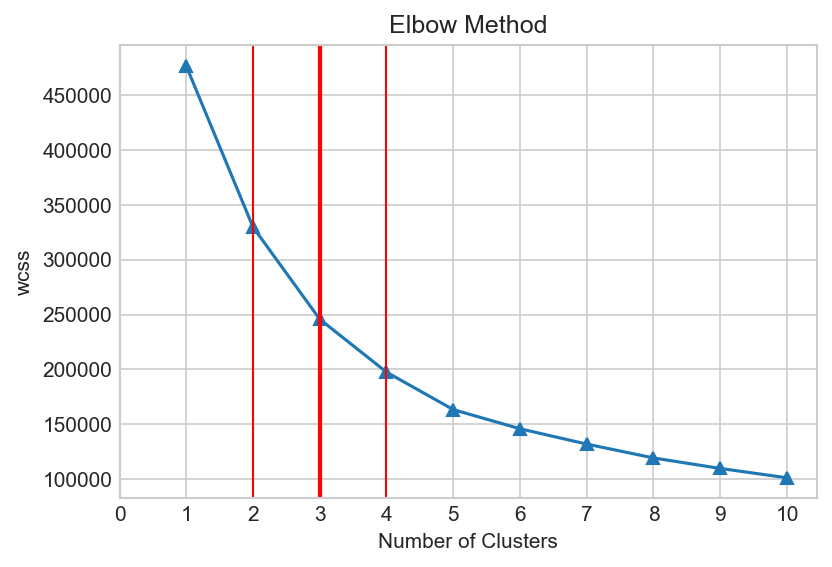

Number of Clusters: 2 , Silhouette score: 0.34335015357854226
Number of Clusters: 3 , Silhouette score: 0.36530506740008956
Number of Clusters: 4 , Silhouette score: 0.33111707245791105
Number of Clusters: 5 , Silhouette score: 0.33519053079358146
Number of Clusters: 6 , Silhouette score: 0.3308478865171296
Number of Clusters: 7 , Silhouette score: 0.27601278118589617
Number of Clusters: 8 , Silhouette score: 0.31056526624724945
Number of Clusters: 9 , Silhouette score: 0.3070072288133817
Number of Clusters: 10 , Silhouette score: 0.31240682962737376
Optimal number of components is: 3


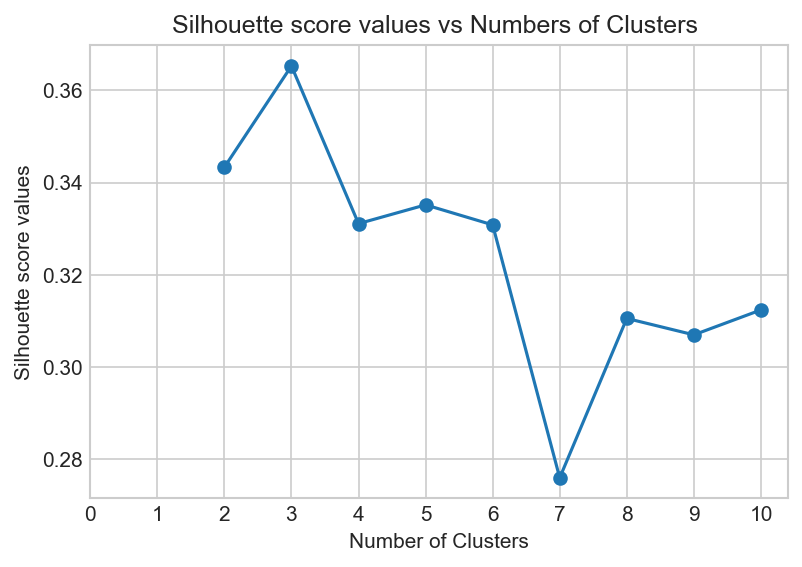

<Figure size 1500x1500 with 0 Axes>

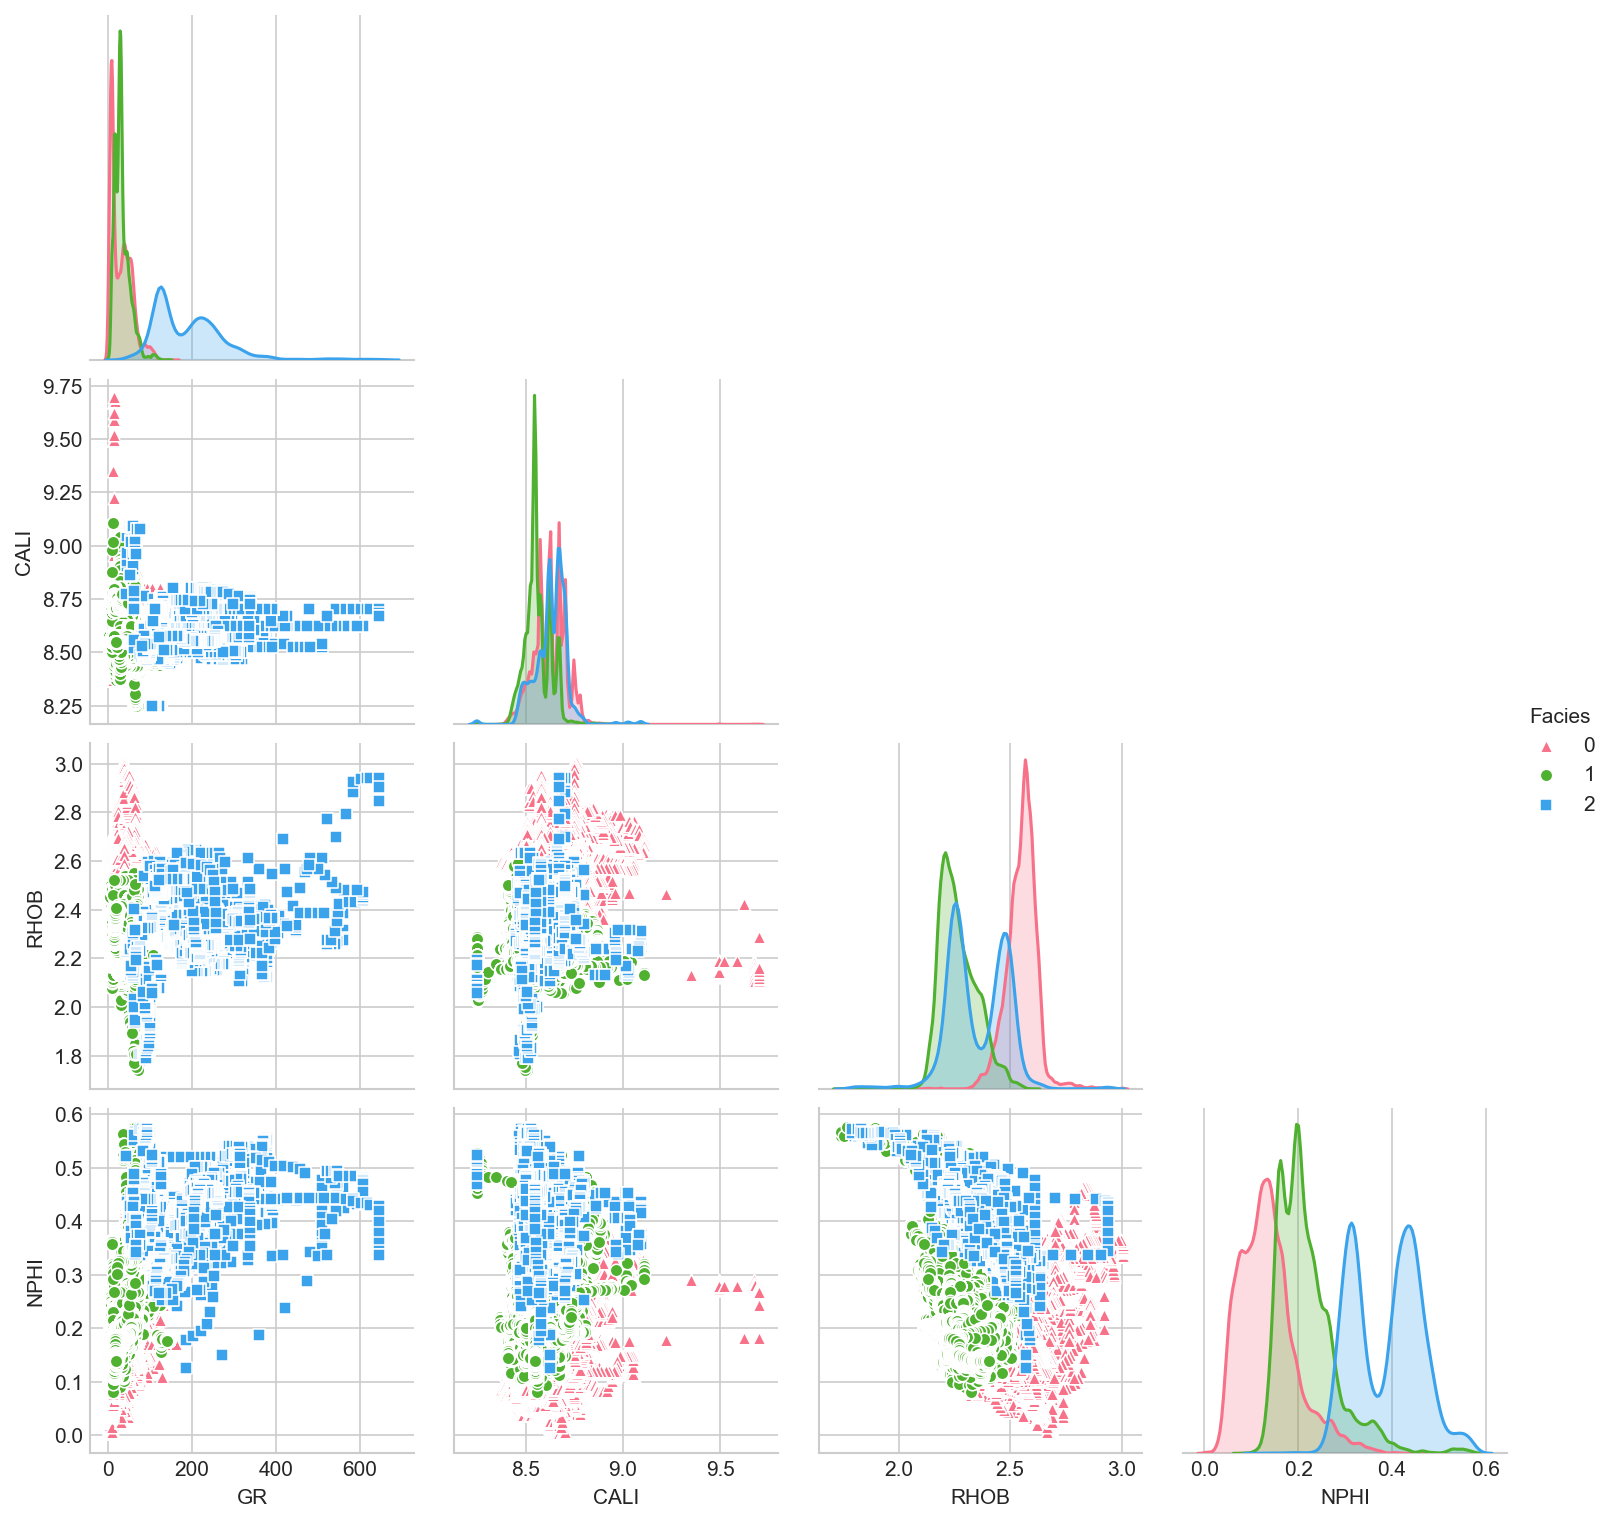

In [382]:
facies_group=['GR', 'CALI', 'RHOB', 'NPHI']#, 'BS', 'ROP', 'RM', 'RD'
dfm=dframe.dropna(subset=facies_group)
dfm[facies_group] = apply_filter(dfm[facies_group], name='All')
data_scaled = DataFrame(Prescale.fit_transform(dfm[facies_group]), 
                        index=dfm[facies_group].index,
                        columns=dfm[facies_group].columns)

df=data_cluster(data_scaled, name='Facies', ncomp=4, nclus=3)
dfm['Facies']=df['Facies']

plt.figure(figsize= (10,10))
ax=sns.pairplot(dfm, vars=facies_group, kind='scatter', diag_kind='kde', hue='Facies', 
                markers=['^','o','s'], palette='husl', height=2.5, corner=True)#, markers=['^','o','s','+','D']

VSHALE Prediction

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119180 entries, 36157 to 359425
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   WELL_NAME  119180 non-null  object 
 1   DEPTH      119180 non-null  float64
 2   GR         119180 non-null  float64
 3   RHOB       119180 non-null  float64
 4   NPHI       119180 non-null  float64
 5   VSH        69705 non-null   float64
 6   Facies     119180 non-null  int32  
dtypes: float64(5), int32(1), object(1)
memory usage: 11.8+ MB
None
Before anomaly treatment
                  GR         RHOB          NPHI           VSH        Facies
count  69705.000000  69705.00000  69705.000000  69705.000000  69705.000000
mean      43.360561      2.40859      0.186834      0.304151      0.535055
std       37.801225      0.15712      0.069603      0.222809      0.555052
min        5.494200      2.05770      0.005000      0.000000      0.000000
25%       20.886200      2.26090      0.146700  

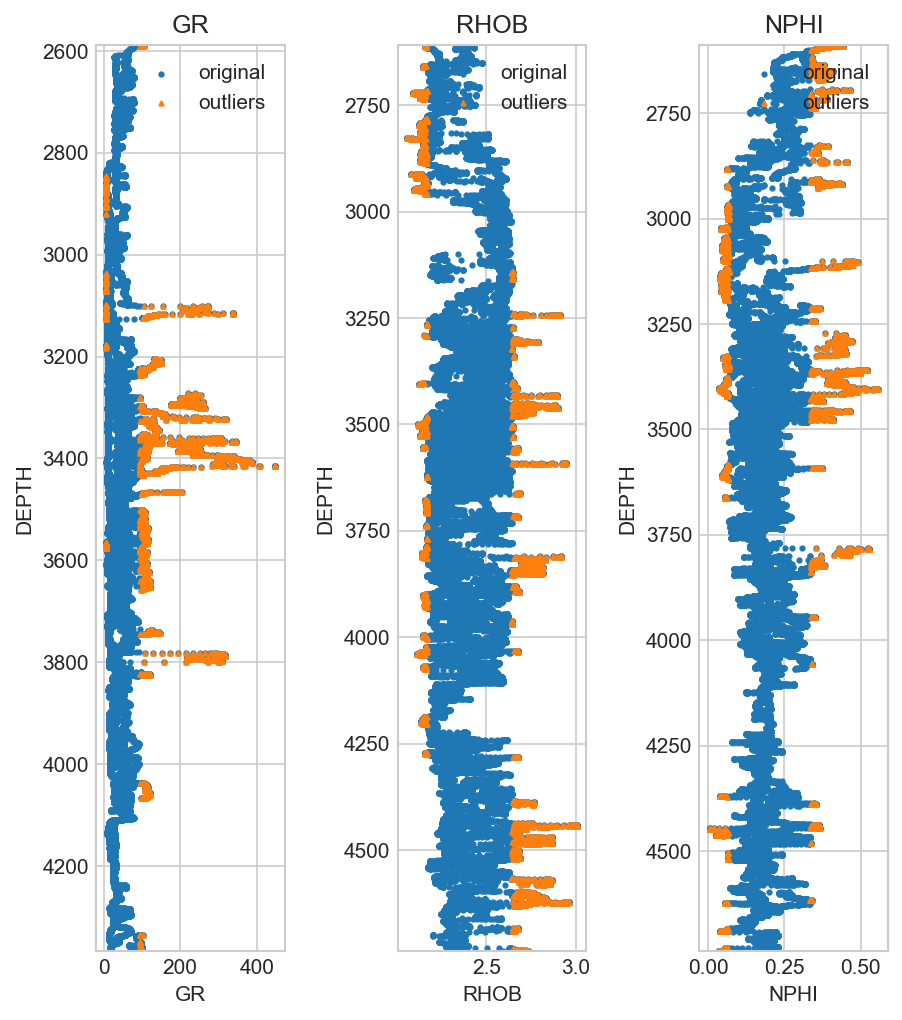

In [383]:
#%% Create DataFrame for each target value - Machine learning
VShale = dfm.drop(['CALI', 'BS', 'ROP', 'RM', 'RD', 'PEF', 'DT', 'DTS', 'VCARB', 'PHIF', 'SW',#
                      'KLOGH', 'SAND_FLAG', 'CARB_FLAG', 'COAL_FLAG'], axis=1)
print(VShale.info())
# drop all nan values from VShale data
VShale.dropna(inplace=True)
VShale.shape

VShale_df=outlier_removal(VShale, ind=-2)

Text(0.5, 1, 'VShale correlation')

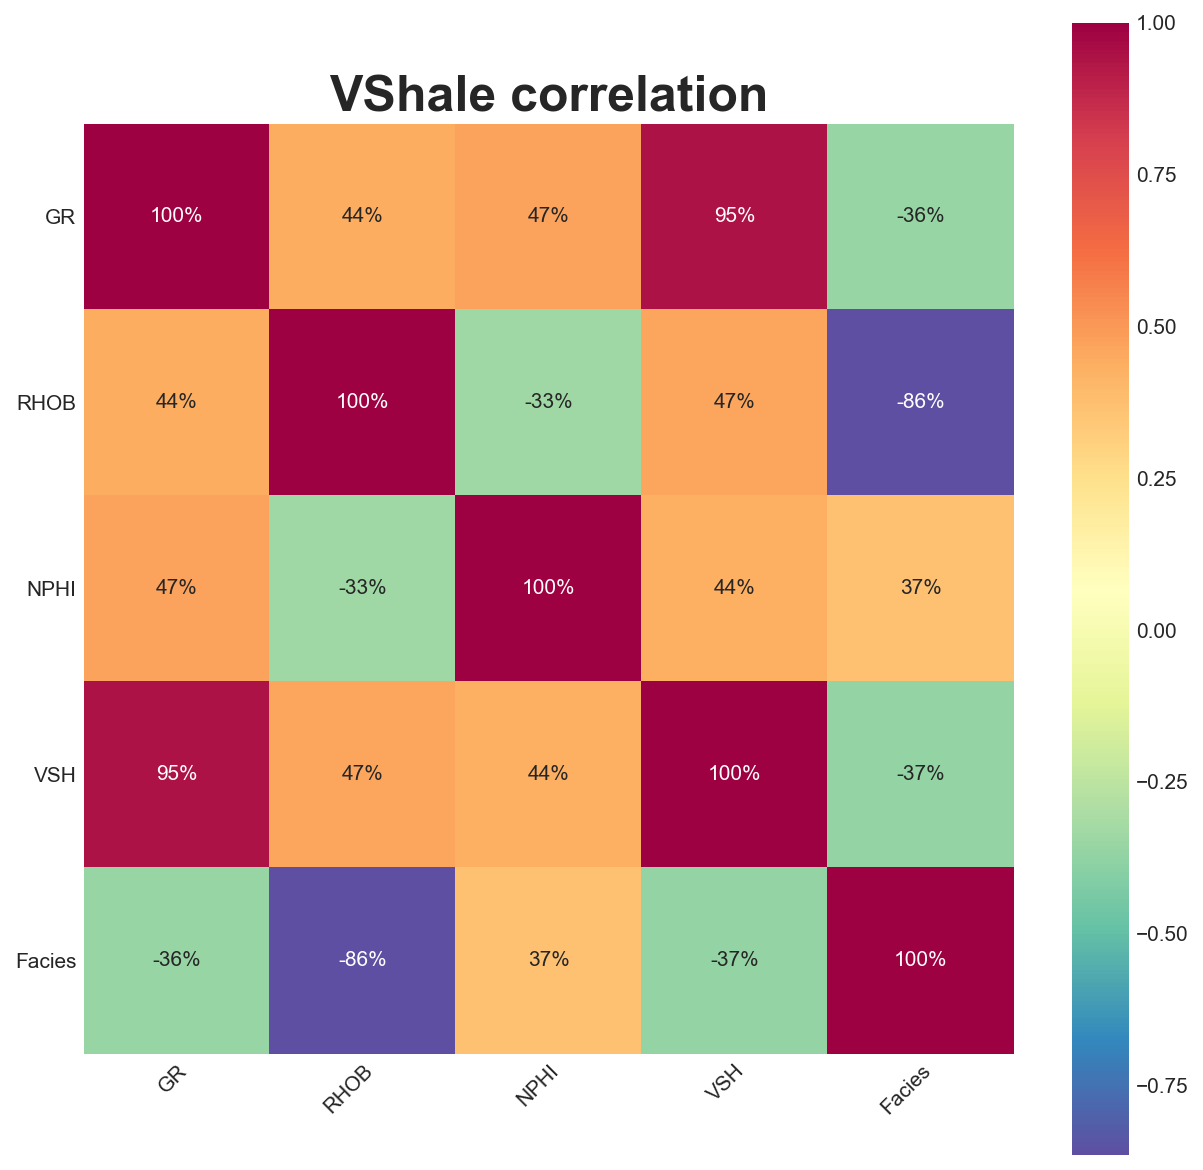

In [384]:
# Visualize correlation
data_scaled = DataFrame(Prescale.fit_transform(VShale_df.drop(['WELL_NAME', 'DEPTH'], axis = 1)), 
                        index=VShale_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).index,
                        columns=VShale_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).columns)
plt.figure(figsize= (10,10))
# Draw a heatmap
ax=sns.heatmap(data_scaled.corr(method='pearson'), annot=True, fmt ='.0%', cmap="Spectral_r", square=True)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
ax.set_title('VShale correlation',weight='bold', fontsize=24)

              DEPTH                                                            \
              count         mean         std        min        25%        50%   
WELL_NAME                                                                       
Well_F1      2284.0  3441.593433   74.200432  3319.9000  3379.4750  3436.5500   
Well_F11A    1515.0  3659.071881   45.612468  3575.2000  3620.2500  3658.1000   
Well_F11B   12092.0  4055.728465  403.750963  3356.5000  3695.5750  4064.3500   
Well_F11T2   1790.0  4436.985754   59.520021  4334.9000  4382.3250  4434.9500   
Well_F15     4497.0  3116.154453  309.160329  2601.0108  2818.1808  3106.3692   
Well_F15A    8836.0  3375.543734  417.097811  2608.6308  3036.5319  3386.5566   
Well_F15B    1297.0  3380.653714   60.764057  3277.3620  3326.7396  3383.4324   
Well_F15C    1766.0  3066.684620   89.174212  2915.8692  2991.8025  3059.0490   
Well_F15D   10828.0  4050.241891  332.159847  3470.1000  3753.0750  4061.9500   
Well_F1A     1905.0  3532.60

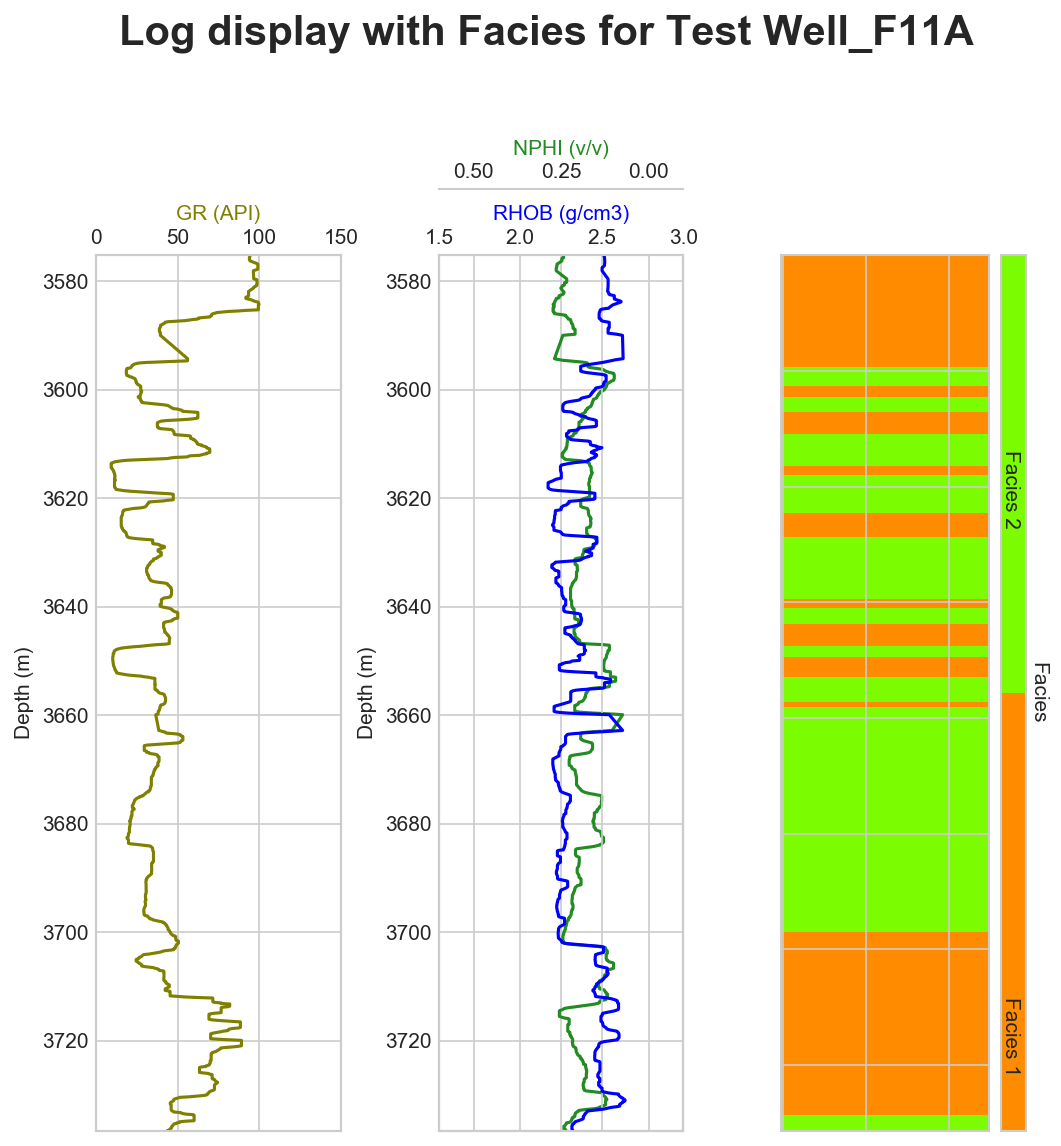

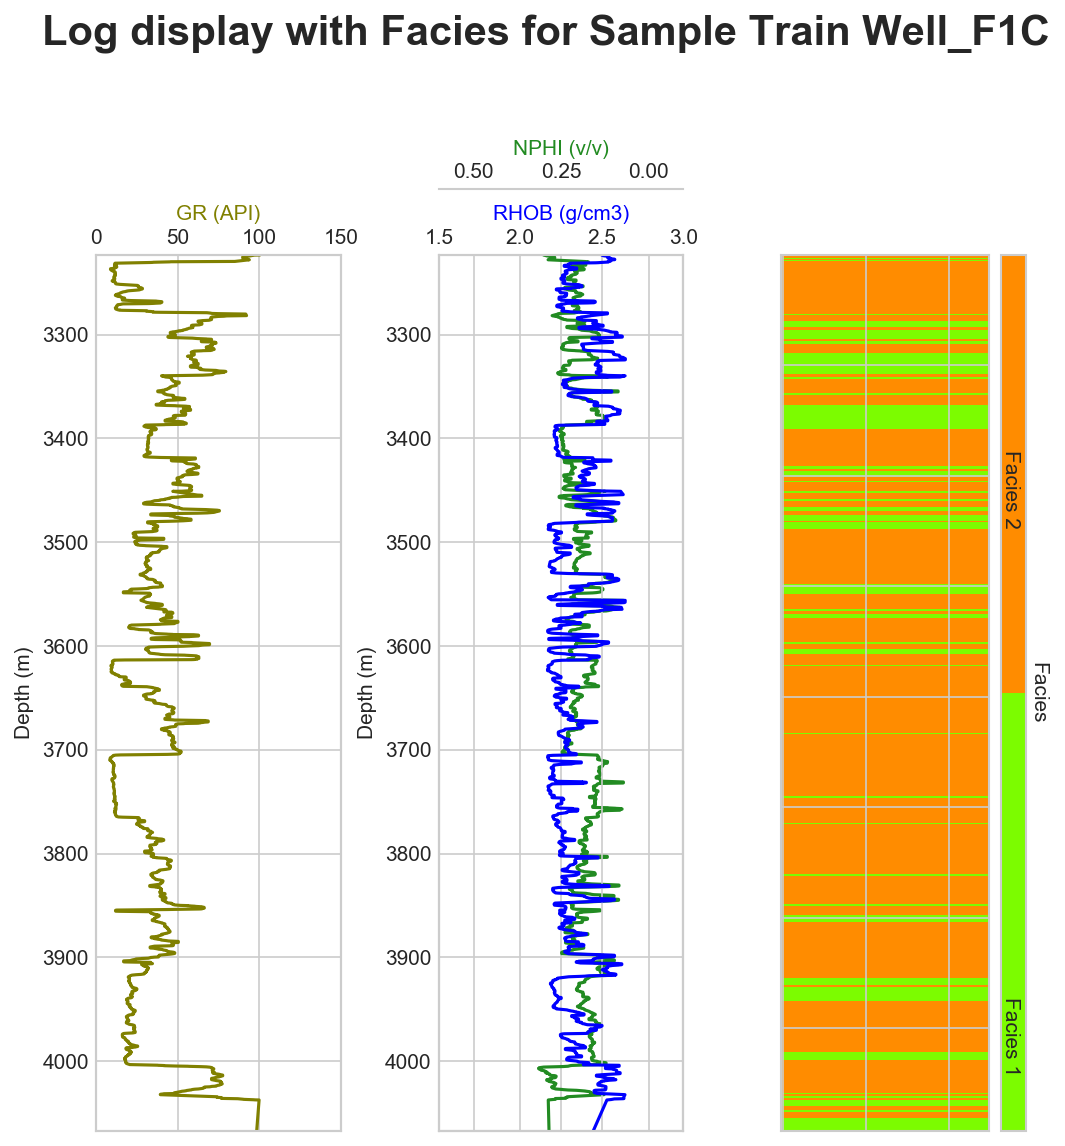

In [385]:
# check out statistics by well 
well_stat=VShale_df.groupby(['WELL_NAME']).describe()
print(well_stat)
# create blind test data with Well_F11A
VShale_blind = VShale_df[VShale_df['WELL_NAME'] == 'Well_F11A']
VShale = VShale_df[VShale_df['WELL_NAME'] != 'Well_F11A']

# Visualising the zone clusters
log_plot (VShale_blind, name='Facies', ycbar=10, title='Log display with Facies for Test')
log_plot (VShale[VShale['WELL_NAME'] == 'Well_F1C'], name='Facies', ycbar=10,
          title='Log display with Facies for Sample Train')

Before applying noise-filter [VShale]
                  GR          RHOB          NPHI
count  29402.000000  29402.000000  29402.000000
mean      30.450373      2.277836      0.194852
std       15.004184      0.077881      0.037268
min        7.318300      2.166500      0.081700
25%       18.105775      2.212700      0.165000
50%       28.412700      2.262000      0.192000
75%       39.317300      2.330000      0.216400
max      100.518799      2.565000      0.335206
After applying noise-filter [VShale]
                  GR          RHOB          NPHI
count  29402.000000  29402.000000  29402.000000
mean      30.520109      2.278216      0.195636
std       14.902718      0.076549      0.036836
min        7.411800      2.166600      0.113300
25%       18.144000      2.214100      0.166000
50%       28.630400      2.263900      0.193000
75%       39.480900      2.329600      0.217300
max       98.574799      2.557000      0.333467


No handles with labels found to put in legend.


GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([  1.,  10., 100.]),
                         'gamma': array([1.00000000e-03, 2.51188643e-02, 6.30957344e-01, 1.58489319e+01])},
             pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
             scoring=['neg_mean_squared_error', 'r2'], verbose=0)
Best: 0.847467 using {'C': 1.0, 'gamma': 0.6309573444801936}
         means     stdev                                       params
rank                                                                 
1     0.847467  0.006979      {'C': 1.0, 'gamma': 0.6309573444801936}
2     0.842853  0.007388    {'C': 1.0, 'gamma': 0.025118864315095808}
3     0.840089  0.007

No handles with labels found to put in legend.


{'C': 100.0, 'gamma': 0.6309573444801936}
Before applying noise-filter [VShale]
                GR        RHOB        NPHI
count  717.000000  717.000000  717.000000
mean    53.791697    2.487732    0.179325
std     24.283472    0.064445    0.051701
min     10.142000    2.336000    0.074000
25%     36.384000    2.456000    0.126000
50%     47.273000    2.487000    0.184000
75%     71.136000    2.528000    0.225000
max     99.835000    2.642000    0.273000
After applying noise-filter [VShale]
                GR        RHOB        NPHI
count  717.000000  717.000000  717.000000
mean    54.145609    2.490874    0.179596
std     24.019568    0.059641    0.050948
min     10.402000    2.364000    0.099000
25%     38.222000    2.457000    0.125000
50%     45.963000    2.488000    0.184000
75%     71.508000    2.526000    0.223000
max     99.438000    2.626000    0.270000


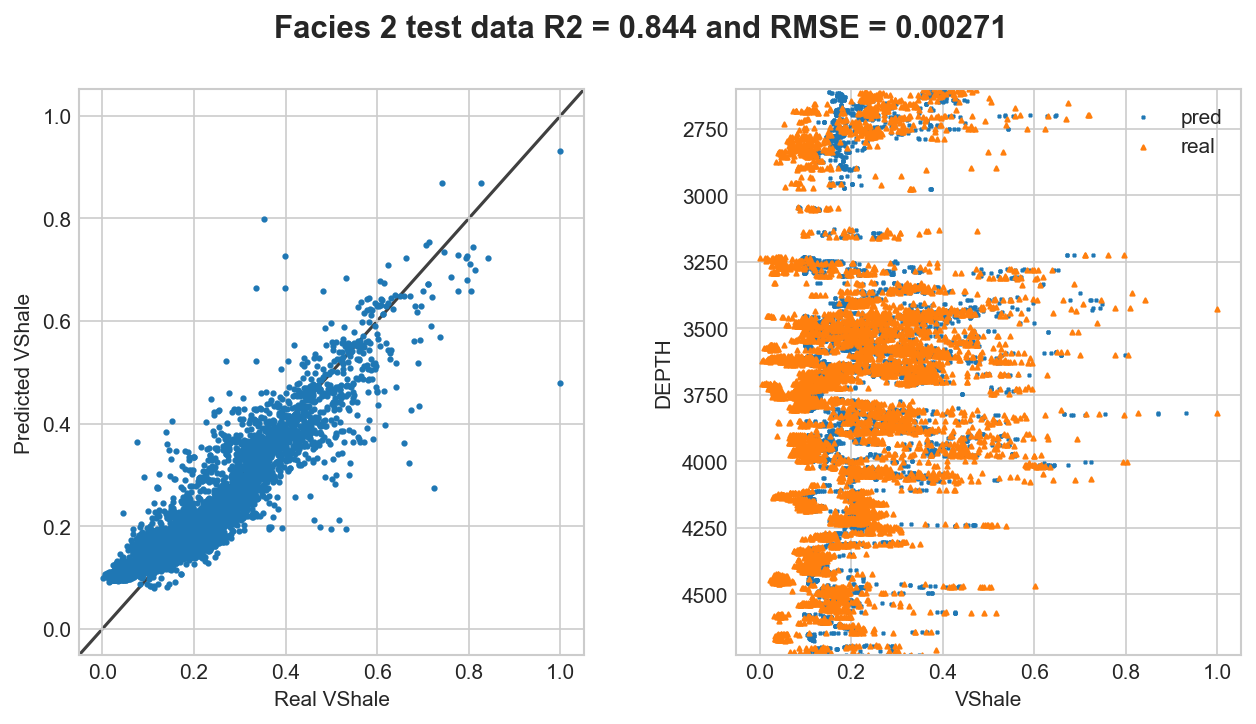

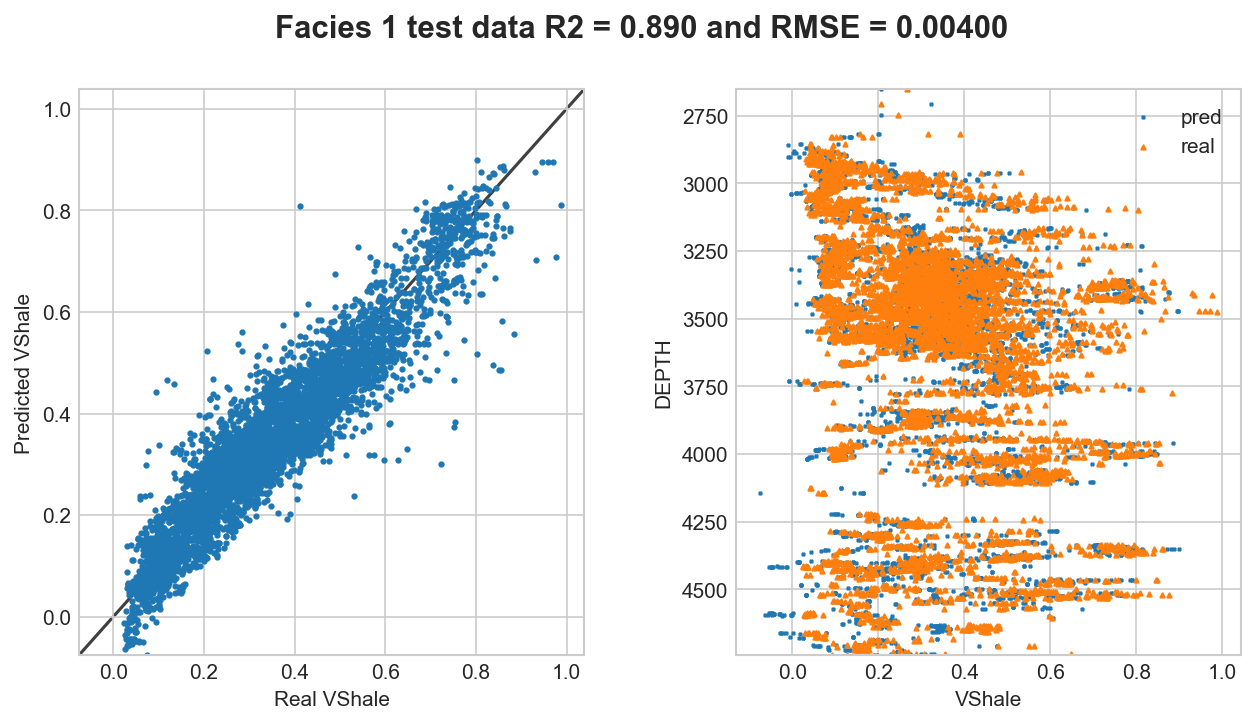

In [388]:
# Split dataset into target and attributes
Y_pred_VShale=np.zeros(VShale_blind.shape[0])# array for saving predictions
name='VShale'
for i in VShale['Facies'].unique():
    VShale_split=VShale[VShale.Facies.values==i].copy()
    target = VShale_split[['DEPTH', 'VSH']]
    target.set_index('DEPTH', inplace=True)
    attributes = VShale_split.drop(['WELL_NAME', 'DEPTH', 'VSH', 'Facies'], axis = 1)
    attributes = apply_filter(attributes, name=name)
    
    model, Prescale, results = model_predict(attributes,target,'Facies %s' % str(i+1), name=name)
    print(model.best_params_)
    
    #BLIND WELL TEST
    VShale_blind_split=VShale_blind[VShale_blind.Facies.values==i].copy()
    Y_blind = VShale_blind_split[['DEPTH', 'VSH']]
    Y_blind.set_index('DEPTH', inplace=True)
    X_blind = VShale_blind_split.drop(['WELL_NAME', 'DEPTH', 'VSH', 'Facies'], axis = 1)
    X_blind = apply_filter(X_blind, name=name)
    

    # save the prediction
    Y_blind_pred = model.predict(Prescale.transform(X_blind))
    Y_pred_VShale[VShale_blind.Facies.values==i]=Y_blind_pred
    
Y_test_VShale=VShale_blind.VSH.values

Text(0.5, 1.0, 'R2 = 0.861 and RMSE = 0.00725')

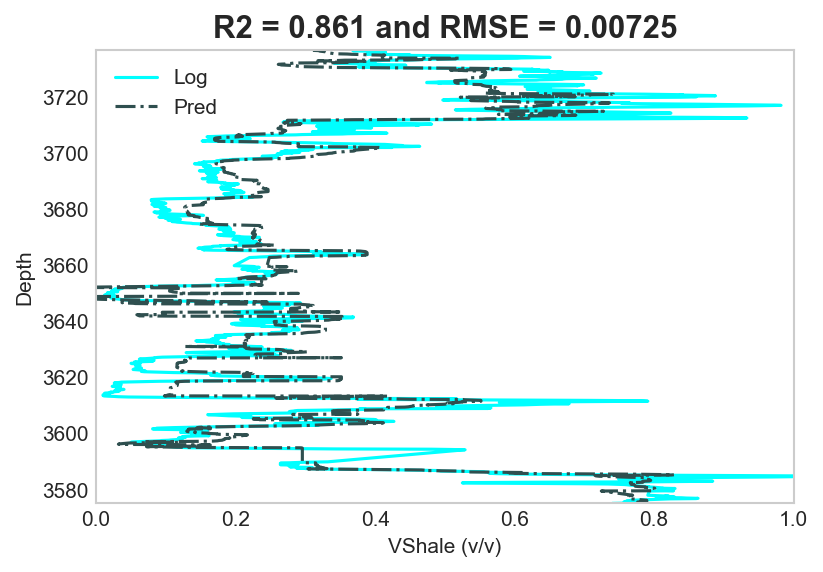

In [389]:
#test the accuracy
mse = mean_squared_error(Y_test_VShale, Y_pred_VShale)
r2 = r2_score(Y_test_VShale, Y_pred_VShale)

plt.plot(Y_test_VShale, VShale_blind.DEPTH, c='cyan')
plt.plot(Y_pred_VShale, VShale_blind.DEPTH, c='darkslategrey', linestyle='-.')
plt.grid()
plt.xlabel('VShale (v/v)')
plt.xlim(0,1) 
plt.ylim(np.min(VShale_blind.DEPTH),np.max(VShale_blind.DEPTH)) 
plt.ylabel('Depth')
plt.legend(['Log', 'Pred'], loc=0)
plt.title('R2 = {:.3f} and RMSE = {:.5f}'.format(r2, mse), weight='bold', fontsize=15)

DT Prediction

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119180 entries, 36157 to 359425
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   WELL_NAME  119180 non-null  object 
 1   DEPTH      119180 non-null  float64
 2   GR         119180 non-null  float64
 3   CALI       119180 non-null  float64
 4   RHOB       119180 non-null  float64
 5   NPHI       119180 non-null  float64
 6   DT         77991 non-null   float64
 7   Facies     119180 non-null  int32  
dtypes: float64(6), int32(1), object(1)
memory usage: 12.7+ MB
None
Before anomaly treatment
                  GR          CALI          RHOB          NPHI            DT  \
count  77991.000000  77991.000000  77991.000000  77991.000000  77991.000000   
mean      40.617470      8.611018      2.474541      0.168194     77.186891   
std       49.550096      0.090364      0.140250      0.093305     14.433990   
min        1.553500      8.371600      2.057700      0.005000     

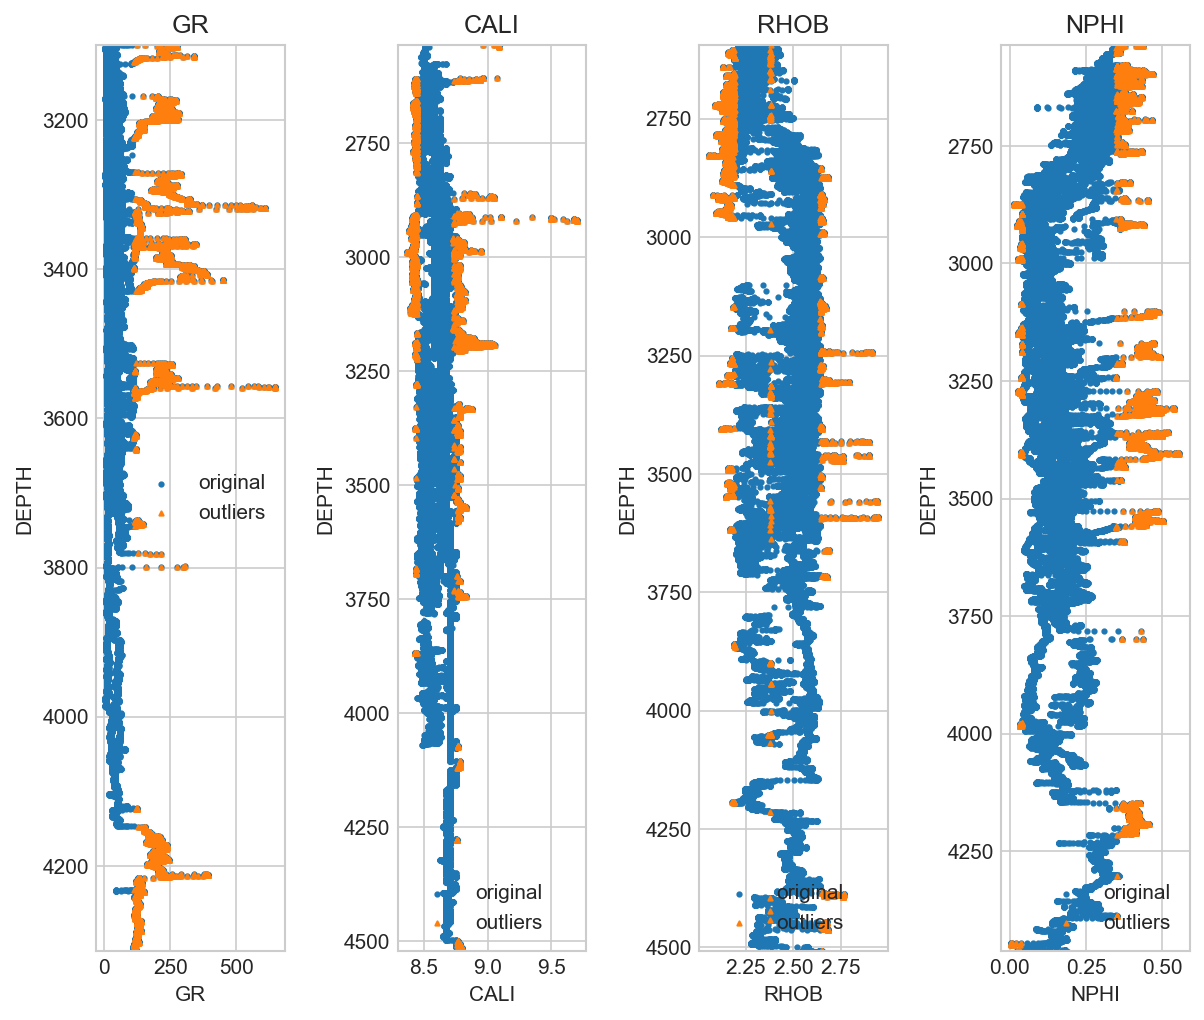

In [393]:
DT = dfm.drop(['BS', 'ROP', 'RM', 'RD', 'DTS', 'VCARB', 'VSH', 'PHIF', 'SW', 'PEF',
                  'KLOGH', 'SAND_FLAG', 'CARB_FLAG', 'COAL_FLAG'], axis=1) 
print(DT.info())
# drop all nan values from VShale data
DT.dropna(inplace=True)
DT.shape

DT_df=outlier_removal(DT, ind=-2)

Text(0.5, 1, 'DT correlation')

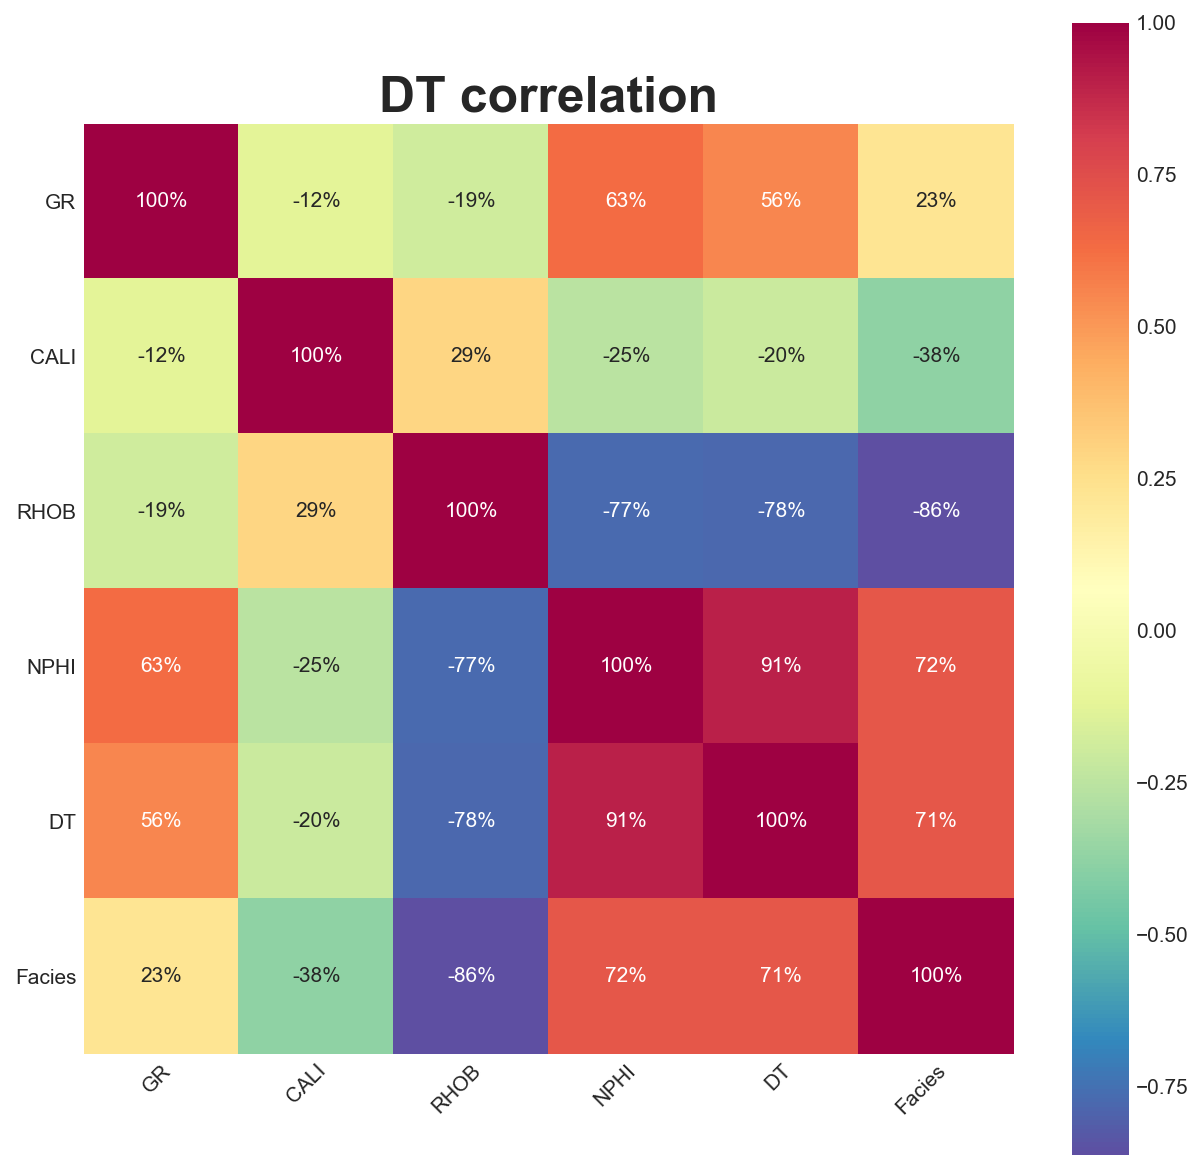

In [394]:
# Visualize correlation
data_scaled = DataFrame(Prescale.fit_transform(DT_df.drop(['WELL_NAME', 'DEPTH'], axis = 1)), 
                        index=DT_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).index,
                        columns=DT_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).columns)
plt.figure(figsize= (10,10))
# Draw a heatmap
ax=sns.heatmap(data_scaled.corr(method='pearson'), annot=True, fmt ='.0%', cmap="Spectral_r", square=True)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
ax.set_title('DT correlation',weight='bold', fontsize=24)

              DEPTH                                                            \
              count         mean         std        min        25%        50%   
WELL_NAME                                                                       
Well_F1      8958.0  3106.156821  283.623195  2618.1000  2864.7250  3093.4500   
Well_F11A    9911.0  3171.080315  311.289289  2577.0000  2923.0500  3172.1000   
Well_F11T2  14978.0  3527.842576  530.545846  2577.0000  3068.1250  3528.0500   
Well_F15     5558.0  3151.019000  309.781504  2539.2888  2925.8133  3193.6182   
Well_F15A    7009.0  3473.143533  375.405162  2616.2508  3231.6420  3501.2376   
Well_F15B    1751.0  3326.546119   83.008278  3174.9492  3256.1022  3322.7772   
Well_F15C     977.0  3023.890382   78.568122  2910.0780  2958.9984  3004.1088   
Well_F1A     8991.0  3117.511111  291.520785  2619.8000  2869.9500  3105.5000   
Well_F1B     2549.0  3275.266301  100.520921  3098.5000  3162.2000  3291.7000   
Well_F5      2600.0  3532.75

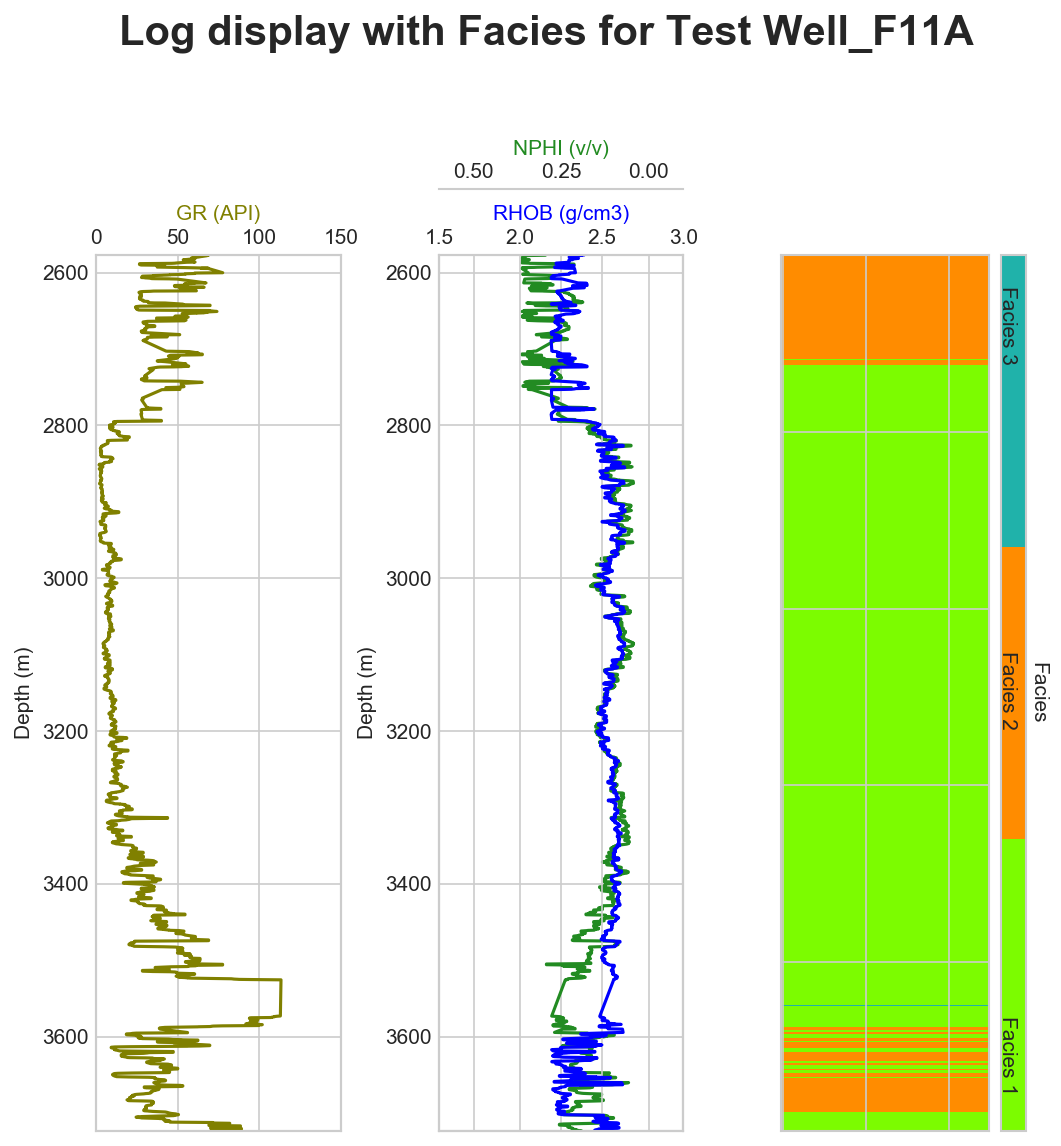

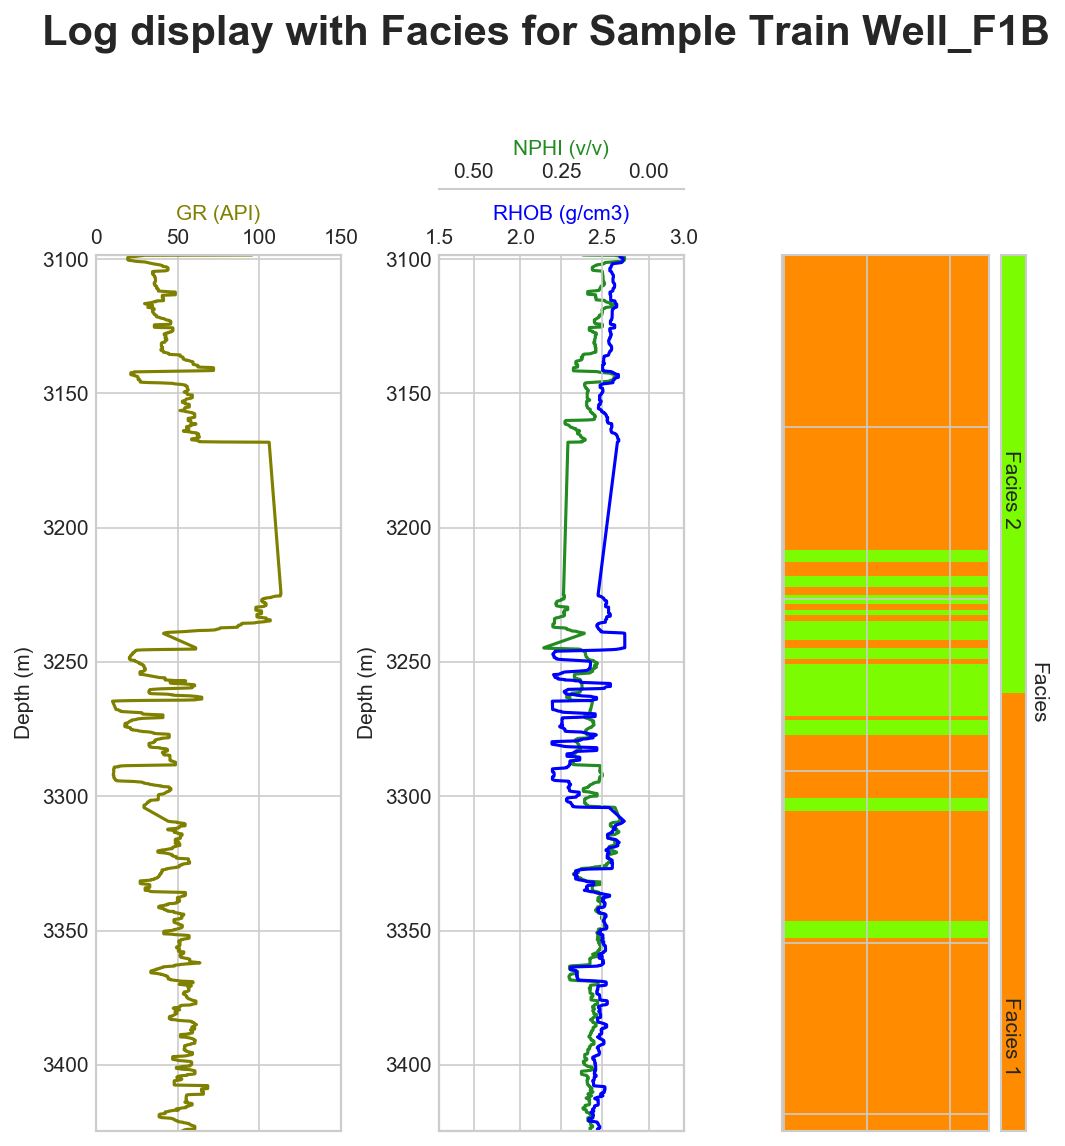

In [395]:
# check out statistics by well 
well_stat=DT_df.groupby(['WELL_NAME']).describe()
print(well_stat)

# create blind test data with Well_F11A
DT_blind = DT_df[DT_df['WELL_NAME'] == 'Well_F11A']
DT = DT_df[DT_df['WELL_NAME'] != 'Well_F11A']

# Visualising the zone clusters
log_plot (DT_blind, name='Facies', ycbar=10, title='Log display with Facies for Test')
log_plot (DT[DT['WELL_NAME'] == 'Well_F1B'], name='Facies', ycbar=10,
          title='Log display with Facies for Sample Train')

Before applying noise-filter [DT]
                  GR          CALI          RHOB          NPHI
count  11308.000000  11308.000000  11308.000000  11308.000000
mean      39.523555      8.544836      2.298356      0.235732
std       17.635450      0.061717      0.080132      0.046238
min        2.385800      8.448600      2.188600      0.090000
25%       29.039500      8.500000      2.232000      0.203000
50%       34.886800      8.546900      2.280000      0.231600
75%       49.286999      8.578000      2.352600      0.259800
max      113.367203      8.758700      2.541200      0.362000
After applying noise-filter [DT]
                  GR          CALI          RHOB          NPHI
count  11308.000000  11308.000000  11308.000000  11308.000000
mean      39.636135      8.545307      2.298775      0.236671
std       17.328934      0.060716      0.078175      0.044834
min        2.539300      8.450000      2.189000      0.131900
25%       29.367201      8.500000      2.233300      0.206200
5

No handles with labels found to put in legend.


{'C': 100.0, 'gamma': 15.848931924611133}
Before applying noise-filter [DT]
                 GR         CALI         RHOB         NPHI
count  1978.000000  1978.000000  1978.000000  1978.000000
mean     37.509560     8.592063     2.266345     0.243646
std      13.075454     0.038030     0.056066     0.059420
min       9.232000     8.535000     2.189000     0.122000
25%      28.702750     8.547000     2.227000     0.206000
50%      34.006000     8.578000     2.249000     0.233000
75%      47.394500     8.625000     2.299000     0.282750
max      77.612000     8.703000     2.417000     0.362000
After applying noise-filter [DT]
                 GR         CALI         RHOB         NPHI
count  1978.000000  1978.000000  1978.000000  1978.000000
mean     37.589909     8.592424     2.267179     0.244753
std      12.676818     0.037999     0.053997     0.058543
min       9.697000     8.547000     2.190000     0.128000
25%      28.831000     8.547000     2.228000     0.207000
50%      34.006000 

No handles with labels found to put in legend.


{'C': 100.0, 'gamma': 15.848931924611133}
Before applying noise-filter [DT]
                 GR         CALI         RHOB         NPHI
count  7929.000000  7929.000000  7929.000000  7929.000000
mean     19.558387     8.648150     2.554329     0.115879
std      19.917398     0.032305     0.048590     0.045385
min       1.812000     8.578000     2.336000     0.043000
25%       7.518000     8.625000     2.520000     0.084000
50%      10.663000     8.625000     2.563000     0.108000
75%      25.452000     8.672000     2.592000     0.136000
max     113.306000     8.750000     2.642000     0.292000
After applying noise-filter [DT]
                 GR         CALI         RHOB         NPHI
count  7929.000000  7929.000000  7929.000000  7929.000000
mean     19.681214     8.648412     2.555075     0.116366
std      19.967748     0.032090     0.047524     0.045223
min       1.975000     8.578000     2.364000     0.044000
25%       7.551000     8.625000     2.521000     0.085000
50%      10.696000 

No handles with labels found to put in legend.


GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([  1.,  10., 100.]),
                         'gamma': array([1.00000000e-03, 2.51188643e-02, 6.30957344e-01, 1.58489319e+01])},
             pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
             scoring=['neg_mean_squared_error', 'r2'], verbose=0)
Best: 0.776528 using {'C': 100.0, 'gamma': 0.6309573444801936}
         means     stdev                                       params
rank                                                                 
1     0.776528  0.162628    {'C': 100.0, 'gamma': 0.6309573444801936}
2     0.742847  0.145583     {'C': 10.0, 'gamma': 0.6309573444801936}
3     0.712700  0.2

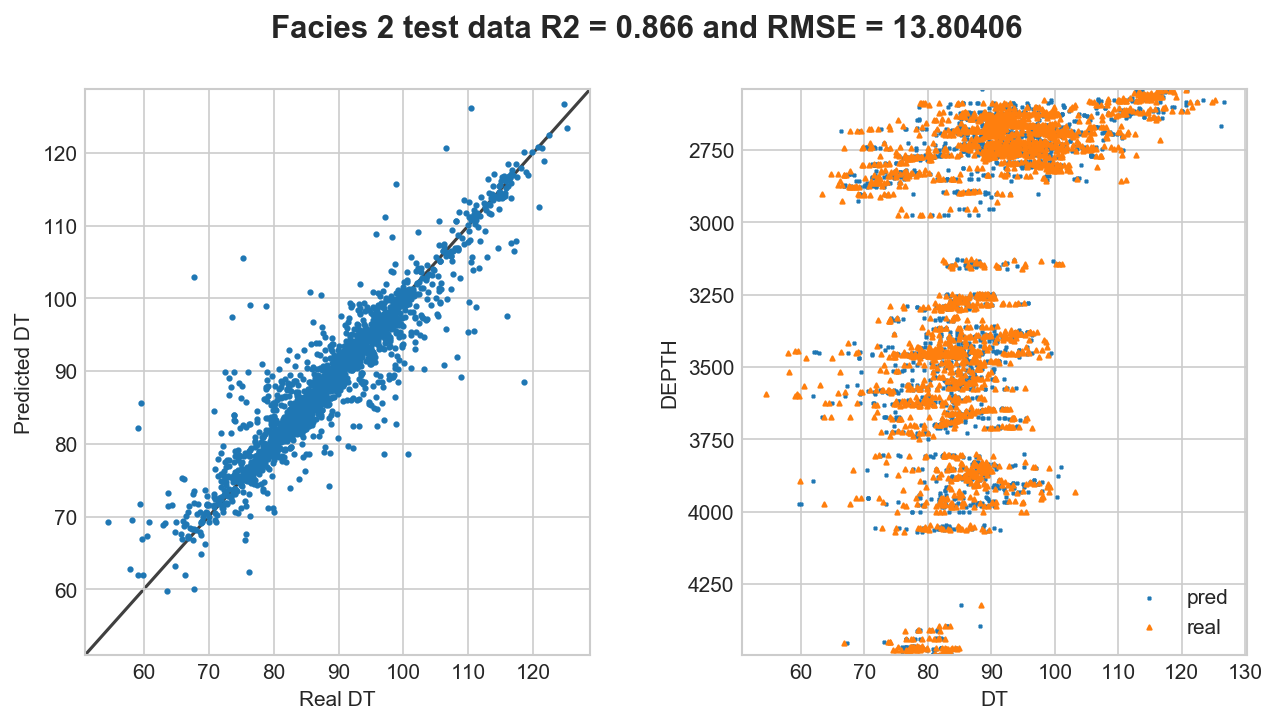

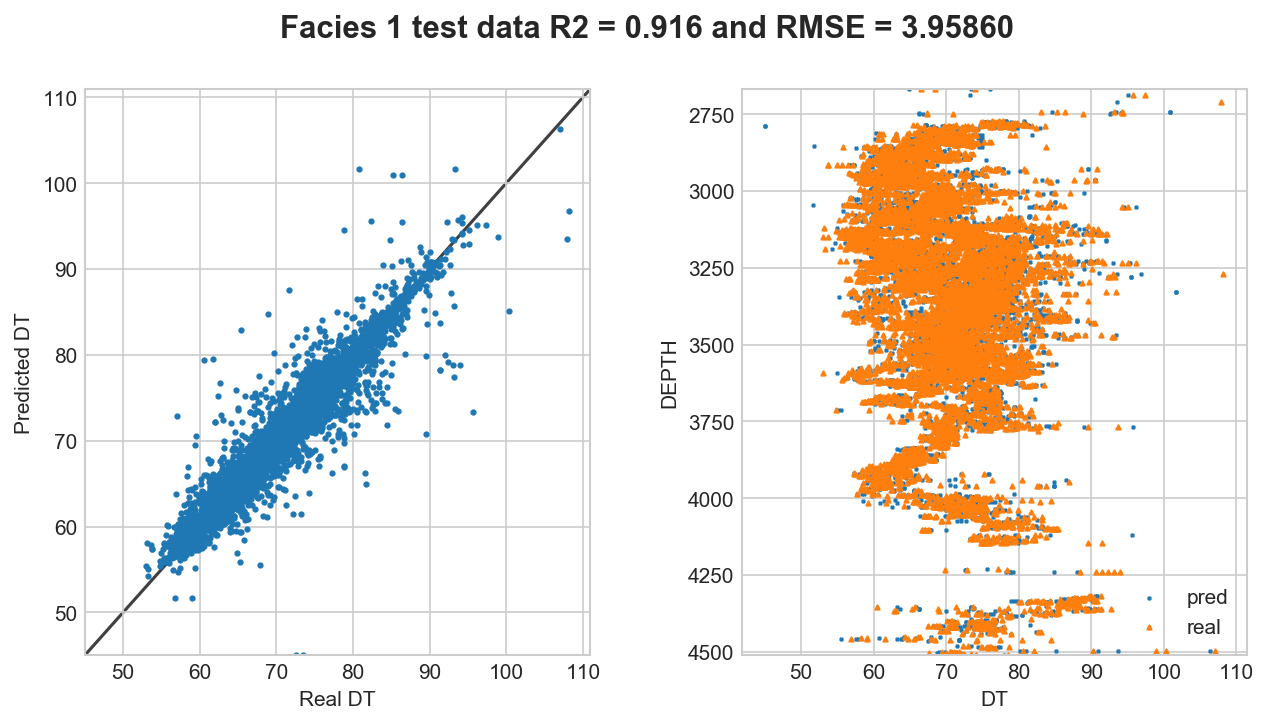

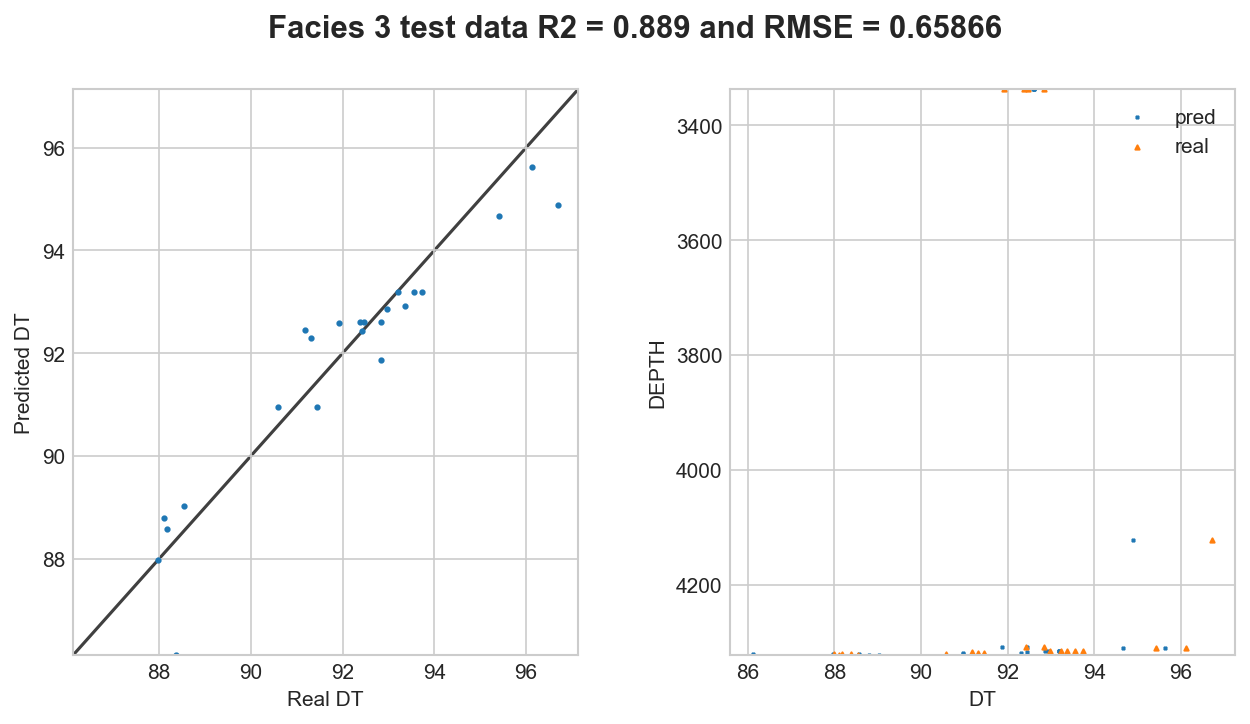

In [396]:
# Split dataset into target and attributes
# arrays for saving predictions
#Y_pred_DT=np.repeat(np.zeros(DT_blind.shape[0]),2).reshape((-1, 2))
Y_pred_DT=np.zeros(DT_blind.shape[0])
name='DT'
for i in DT['Facies'].unique():
    DT_split=DT[DT.Facies.values==i].copy()
    target = DT_split[['DEPTH', 'DT']]
    target.set_index('DEPTH', inplace=True)
    attributes = DT_split.drop(['WELL_NAME', 'DEPTH', 'DT', 'Facies'], axis = 1)
    attributes = apply_filter(attributes, name=name)
    
    model, Prescale, results = model_predict(attributes,target,'Facies %s' % str(i+1), name=name)
    print(model.best_params_)
    
    #BLIND WELL TEST
    DT_blind_split=DT_blind[DT_blind.Facies.values==i].copy()
    Y_blind = DT_blind_split[['DEPTH', 'DT']]
    Y_blind.set_index('DEPTH', inplace=True)
    X_blind = DT_blind_split.drop(['WELL_NAME', 'DEPTH', 'DT', 'Facies'], axis = 1)
    X_blind = apply_filter(X_blind, name=name)
    

    # save the prediction
    Y_blind_pred = model.predict(Prescale.transform(X_blind))
    Y_pred_DT[DT_blind.Facies.values==i]=Y_blind_pred
    
Y_test_DT=DT_blind['DT'].values

Text(0.5, 1.0, 'R2 = 0.785 and RMSE = 30.10841')

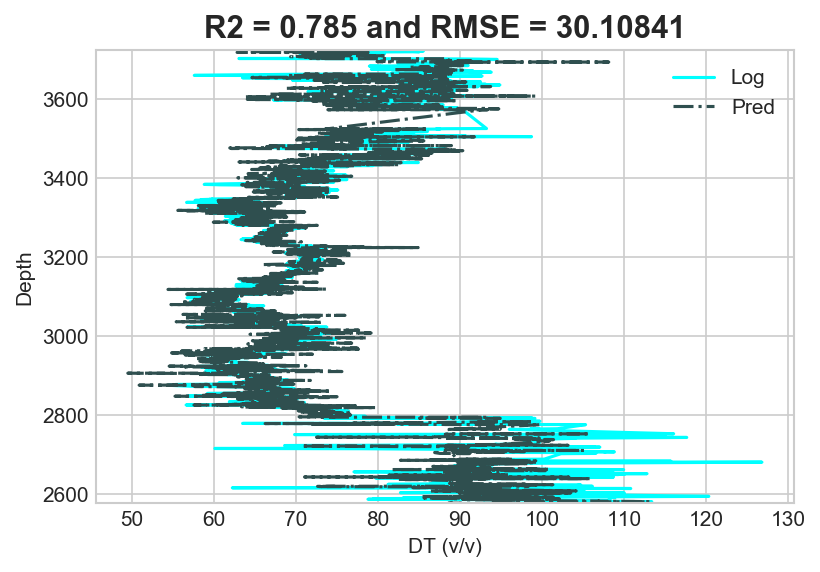

In [397]:
#test the accuracy
mse = mean_squared_error(Y_test_DT, Y_pred_DT)
r2 = r2_score(Y_test_DT, Y_pred_DT)

plt.plot(Y_test_DT, DT_blind.DEPTH, c='cyan')
plt.plot(Y_pred_DT, DT_blind.DEPTH, c='darkslategrey', linestyle='-.')
plt.xlabel('DT (v/v)')
#plt.xlim(0,1) 
plt.ylim(np.min(DT_blind.DEPTH),np.max(DT_blind.DEPTH)) 
plt.ylabel('Depth')
plt.legend(['Log', 'Pred'], loc=0)
plt.title('R2 = {:.3f} and RMSE = {:.5f}'.format(r2, mse), weight='bold', fontsize=15)

DTS Prediction

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119180 entries, 36157 to 359425
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   WELL_NAME  119180 non-null  object 
 1   DEPTH      119180 non-null  float64
 2   GR         119180 non-null  float64
 3   CALI       119180 non-null  float64
 4   RHOB       119180 non-null  float64
 5   NPHI       119180 non-null  float64
 6   PEF        111629 non-null  float64
 7   DTS        42812 non-null   float64
 8   Facies     119180 non-null  int32  
dtypes: float64(7), int32(1), object(1)
memory usage: 13.6+ MB
None
Before anomaly treatment
                  GR          CALI          RHOB          NPHI           PEF  \
count  42812.000000  42812.000000  42812.000000  42812.000000  42812.000000   
mean      34.318402      8.652205      2.489143      0.156701      7.328544   
std       45.230072      0.056168      0.134222      0.089918      1.195515   
min        1.812000      

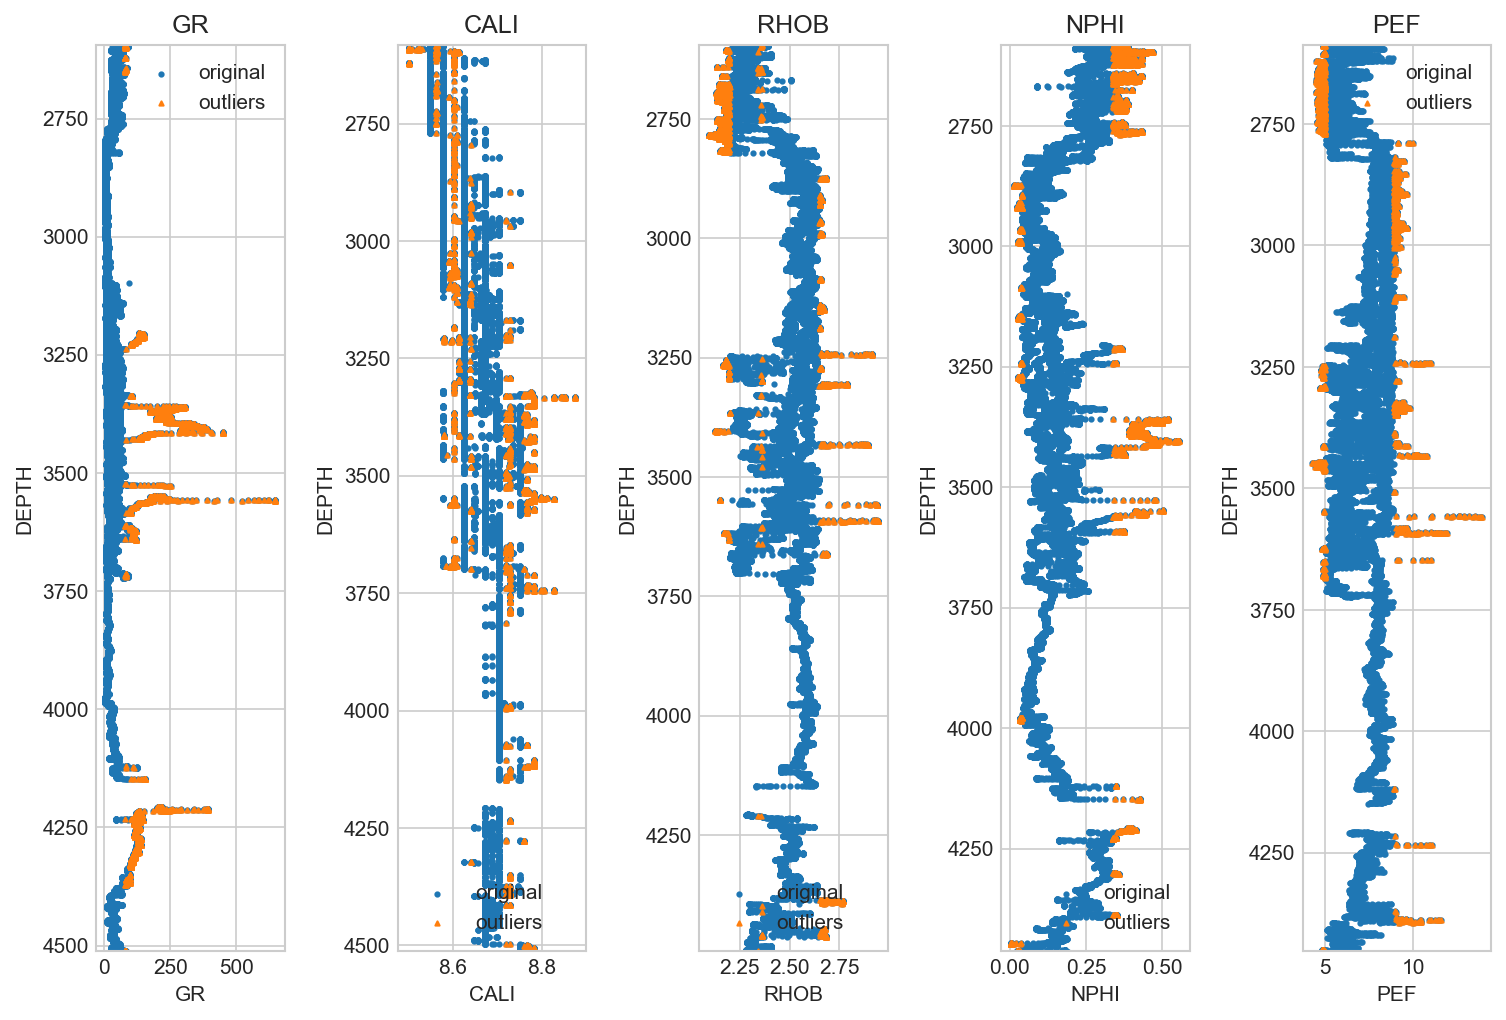

In [399]:
DTS = dfm.drop(['BS', 'ROP', 'RM', 'RD', 'DT', 'VCARB', 'VSH', 'PHIF', 'SW',# 'PEF',
                  'KLOGH', 'SAND_FLAG', 'CARB_FLAG', 'COAL_FLAG'], axis=1) 
print(DTS.info())
# drop all nan values from VShale data
DTS.dropna(inplace=True)
DTS.shape

DTS_df=outlier_removal(DTS, ind=-2)

Text(0.5, 1, 'DTS correlation')

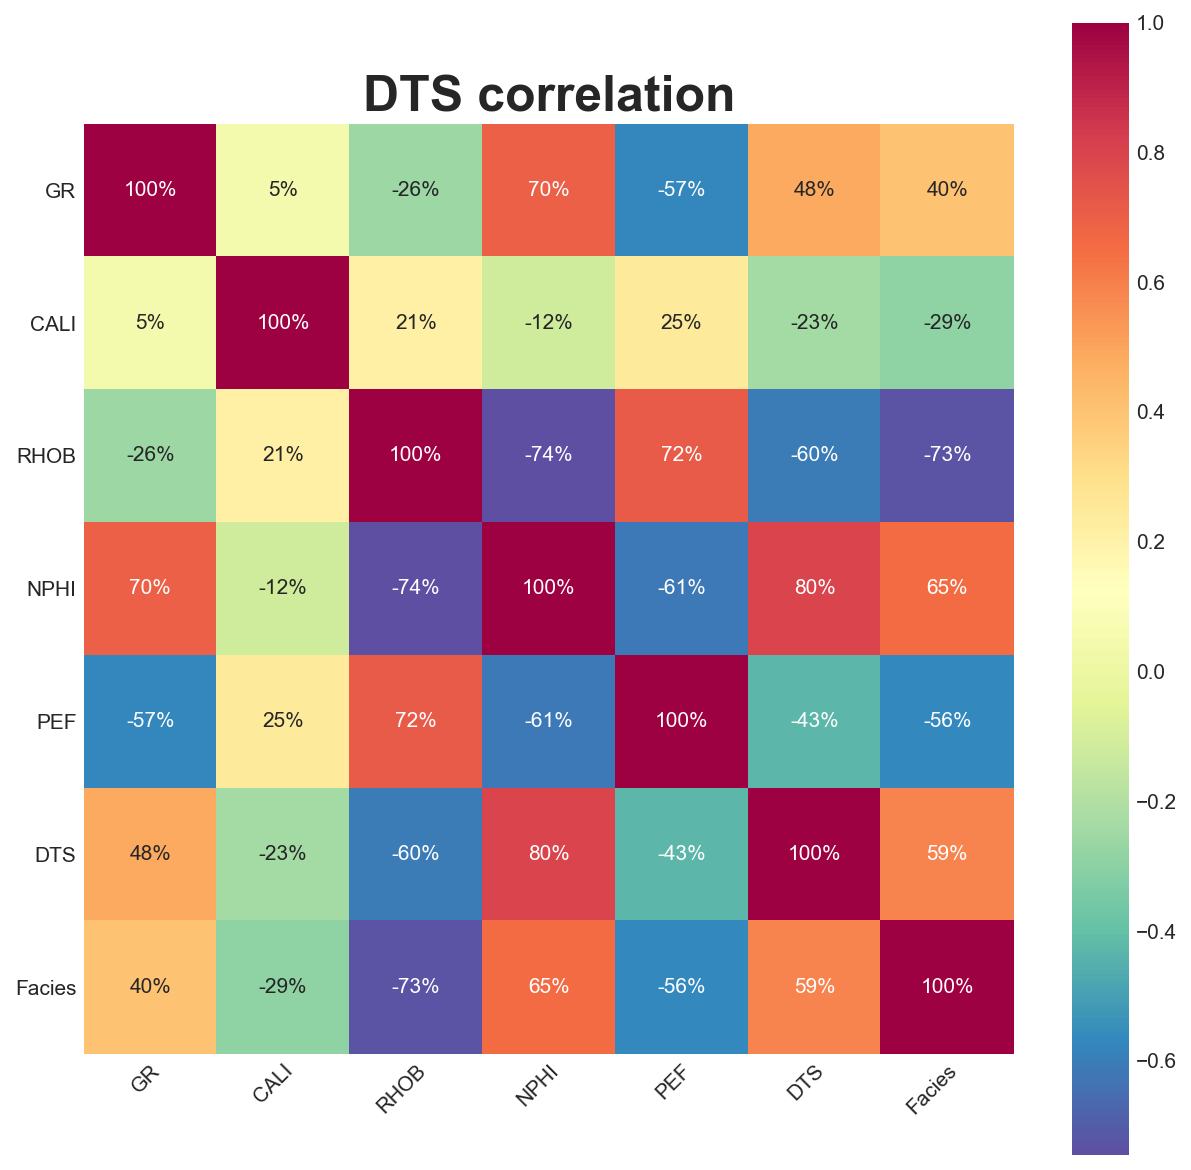

In [402]:
# Visualize correlation
data_scaled = DataFrame(Prescale.fit_transform(DTS_df.drop(['WELL_NAME', 'DEPTH'], axis = 1)), 
                        index=DTS_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).index,
                        columns=DTS_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).columns)
plt.figure(figsize= (10,10))
# Draw a heatmap
ax=sns.heatmap(data_scaled.corr(method='pearson'), annot=True, fmt ='.0%', cmap="Spectral_r", square=True)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
ax.set_title('DTS correlation',weight='bold', fontsize=24)

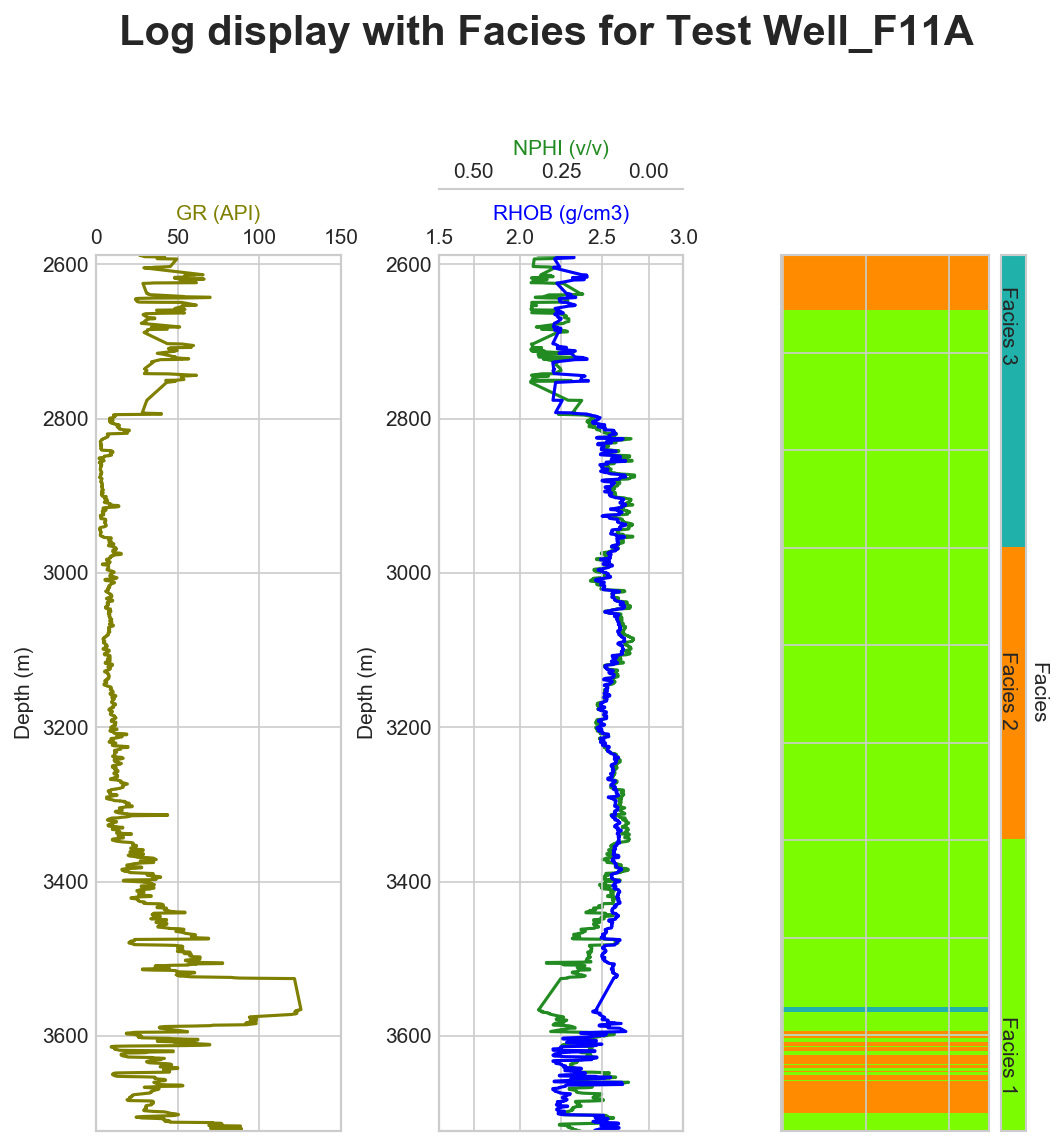

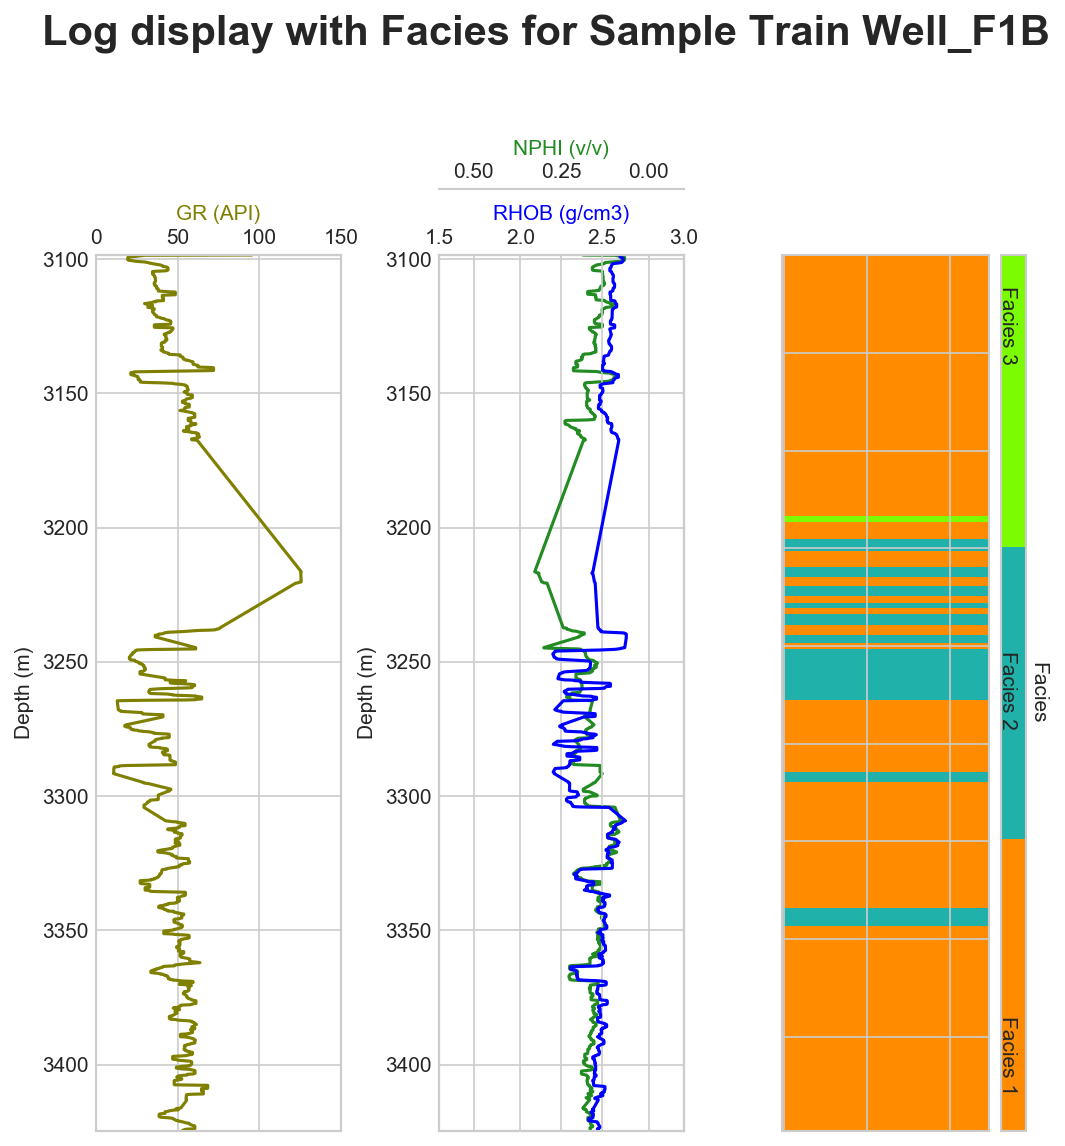

In [403]:
# create blind test data with Well_F11A
DTS_blind = DTS_df[DTS_df['WELL_NAME'] == 'Well_F11A']
DTS = DTS_df[DTS_df['WELL_NAME'] != 'Well_F11A']

# Visualising the zone clusters
log_plot (DTS_blind, name='Facies', ycbar=10, title='Log display with Facies for Test')
log_plot (DTS[DTS['WELL_NAME'] == 'Well_F1B'], name='Facies', ycbar=10,
          title='Log display with Facies for Sample Train')

Before applying noise-filter [DTS]
                 GR         CALI         RHOB        NPHI          PEF
count  2463.000000  2463.000000  2463.000000  2463.00000  2463.000000
mean     35.940919     8.605315     2.290741     0.22695     5.633677
std      12.320390     0.047684     0.063367     0.04221     0.566131
min       7.801400     8.546900     2.198000     0.09000     5.013300
25%      27.606000     8.578000     2.237000     0.19340     5.275000
50%      33.356000     8.578100     2.287000     0.22320     5.465000
75%      44.073500     8.663700     2.326700     0.25100     5.759200
max      95.859800     8.703200     2.518600     0.33700     8.791000
After applying noise-filter [DTS]
                 GR         CALI         RHOB         NPHI          PEF
count  2463.000000  2463.000000  2463.000000  2463.000000  2463.000000
mean     36.031103     8.605344     2.291958     0.227624     5.626020
std      11.600935     0.047430     0.060746     0.040941     0.511509
min      10.975

No handles with labels found to put in legend.


GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([  1.,  10., 100.]),
                         'gamma': array([1.00000000e-03, 2.51188643e-02, 6.30957344e-01, 1.58489319e+01])},
             pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
             scoring=['neg_mean_squared_error', 'r2'], verbose=0)
Best: 0.913962 using {'C': 100.0, 'gamma': 0.6309573444801936}
         means     stdev                                       params
rank                                                                 
1     0.913962  0.015300    {'C': 100.0, 'gamma': 0.6309573444801936}
2     0.885615  0.030134    {'C': 100.0, 'gamma': 15.848931924611133}
3     0.822276  0.0

No handles with labels found to put in legend.


{'C': 100.0, 'gamma': 15.848931924611133}
Before applying noise-filter [DTS]
                 GR         CALI         RHOB         NPHI          PEF
count  7715.000000  7715.000000  7715.000000  7715.000000  7715.000000
mean     18.802377     8.647850     2.555251     0.114469     7.951028
std      18.489925     0.031723     0.048175     0.043808     0.625500
min       1.812000     8.578000     2.336000     0.040000     5.086000
25%       7.518000     8.625000     2.521000     0.083000     7.757000
50%      10.591000     8.625000     2.564000     0.107000     8.154000
75%      24.410000     8.672000     2.592000     0.135000     8.362000
max     121.560000     8.750000     2.647000     0.292000     8.909000
After applying noise-filter [DTS]
                 GR         CALI         RHOB         NPHI          PEF
count  7715.000000  7715.000000  7715.000000  7715.000000  7715.000000
mean     18.909851     8.648202     2.556018     0.114971     7.957708
std      18.502929     0.031473    

No handles with labels found to put in legend.


GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([  1.,  10., 100.]),
                         'gamma': array([1.00000000e-03, 2.51188643e-02, 6.30957344e-01, 1.58489319e+01])},
             pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
             scoring=['neg_mean_squared_error', 'r2'], verbose=0)
Best: 0.777923 using {'C': 100.0, 'gamma': 0.6309573444801936}
         means     stdev                                       params
rank                                                                 
1     0.777923  0.126441    {'C': 100.0, 'gamma': 0.6309573444801936}
2     0.713497  0.148938     {'C': 10.0, 'gamma': 0.6309573444801936}
3     0.521573  0.2

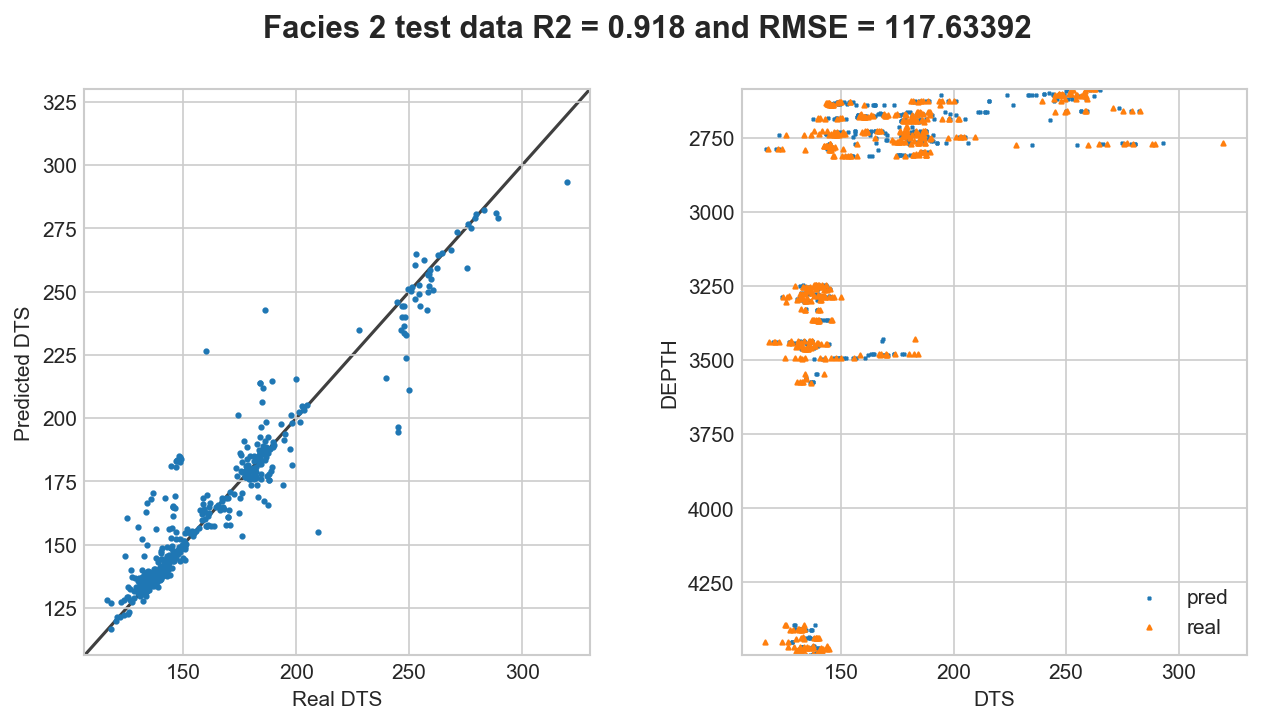

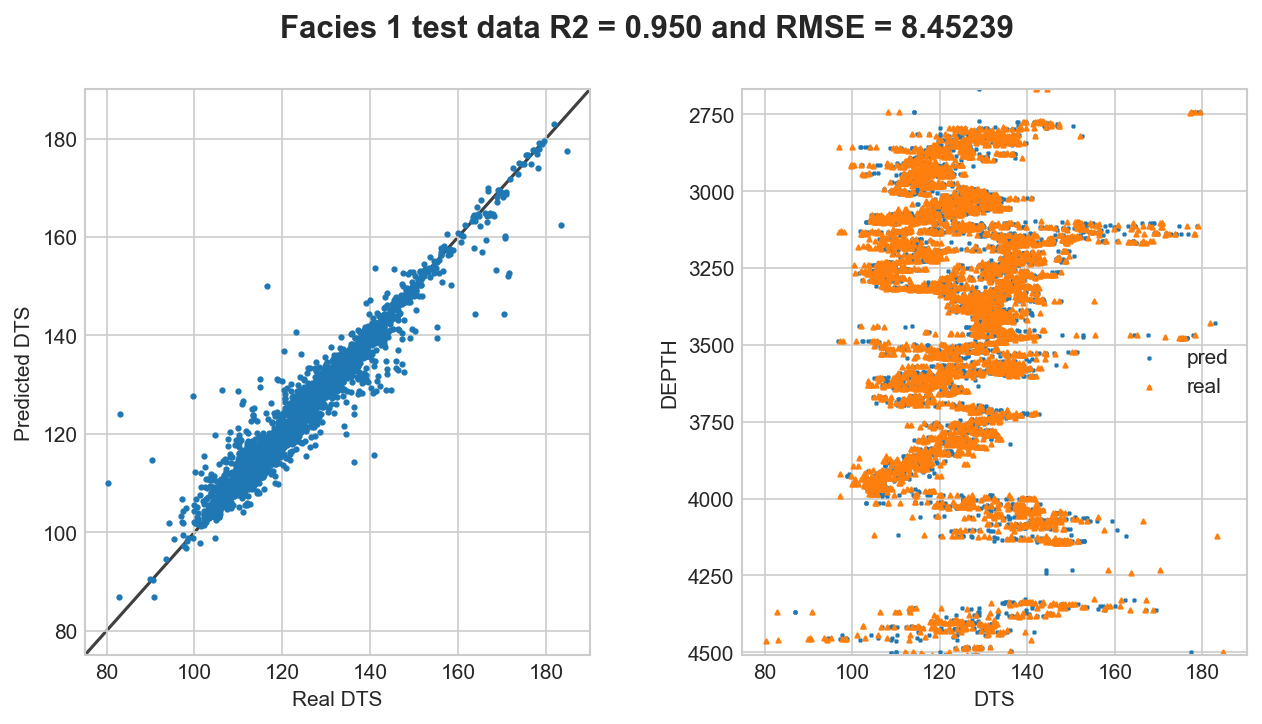

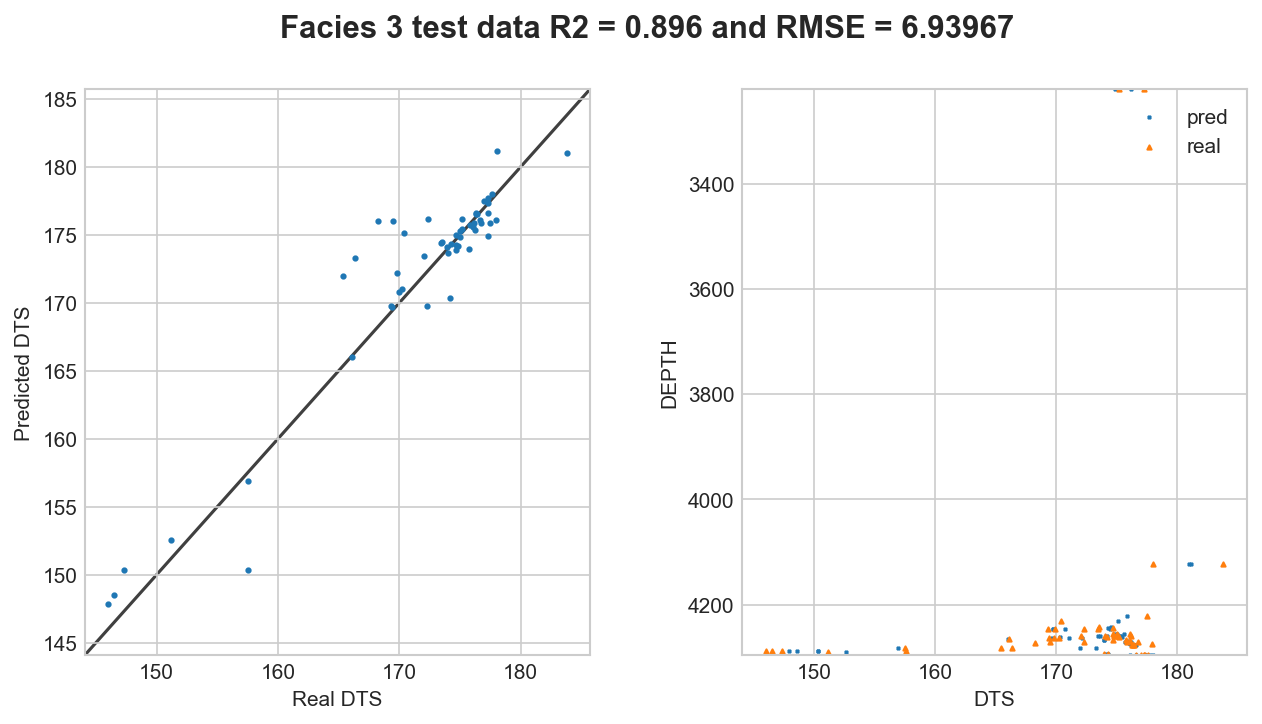

In [404]:
# Split dataset into target and attributes
# arrays for saving predictions
Y_pred_DTS=np.zeros(DTS_blind.shape[0])
name='DTS'
for i in DTS['Facies'].unique():
    DTS_split=DTS[DTS.Facies.values==i].copy()
    target = DTS_split[['DEPTH', 'DTS']]
    target.set_index('DEPTH', inplace=True)
    attributes = DTS_split.drop(['WELL_NAME', 'DEPTH', 'DTS', 'Facies'], axis = 1)
    attributes = apply_filter(attributes, name=name)
    
    model, Prescale, results = model_predict(attributes,target,'Facies %s' % str(i+1), name=name)
    print(model.best_params_)
    
    #BLIND WELL TEST
    DTS_blind_split=DTS_blind[DTS_blind.Facies.values==i].copy()
    Y_blind = DTS_blind_split[['DEPTH', 'DTS']]
    Y_blind.set_index('DEPTH', inplace=True)
    X_blind = DTS_blind_split.drop(['WELL_NAME', 'DEPTH', 'DTS', 'Facies'], axis = 1)
    X_blind = apply_filter(X_blind, name=name)
    

    # save the prediction
    Y_blind_pred = model.predict(Prescale.transform(X_blind))
    Y_pred_DTS[DTS_blind.Facies.values==i]=Y_blind_pred
    
Y_test_DTS=DTS_blind['DTS'].values

Text(0.5, 1.0, 'R2 = 0.599 and RMSE = 340.46869')

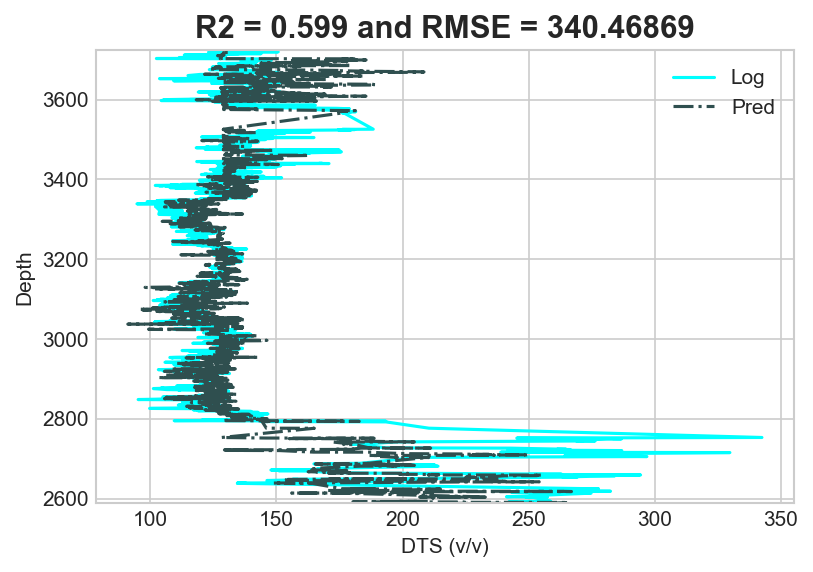

In [406]:
#test the accuracy
mse = mean_squared_error(Y_test_DTS, Y_pred_DTS)
r2 = r2_score(Y_test_DTS, Y_pred_DTS)

plt.plot(Y_test_DTS, DTS_blind.DEPTH, c='cyan')
plt.plot(Y_pred_DTS, DTS_blind.DEPTH, c='darkslategrey', linestyle='-.')
plt.xlabel('DTS (v/v)')
#plt.xlim(0,1) 
plt.ylim(np.min(DTS_blind.DEPTH),np.max(DTS_blind.DEPTH)) 
plt.ylabel('Depth')
plt.legend(['Log', 'Pred'], loc=0)
plt.title('R2 = {:.3f} and RMSE = {:.5f}'.format(r2, mse), weight='bold', fontsize=15)

PORO Prediction

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348110 entries, 0 to 359591
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   WELL_NAME  348110 non-null  object 
 1   DEPTH      348110 non-null  float64
 2   GR         345801 non-null  float64
 3   RHOB       160609 non-null  float64
 4   NPHI       143927 non-null  float64
 5   PHIF       81516 non-null   float64
dtypes: float64(5), object(1)
memory usage: 18.6+ MB
None
Before anomaly treatment
                  GR          RHOB          NPHI          PHIF
count  81471.000000  81471.000000  81471.000000  81471.000000
mean      45.269673      2.411504      0.184874      0.141086
std       38.624963      0.157998      0.070716      0.081239
min        2.675900      1.387600     -0.003000      0.000000
25%       21.907950      2.264300      0.143200      0.066800
50%       36.741100      2.430000      0.178800      0.134500
75%       56.437550      2.546000      0.217

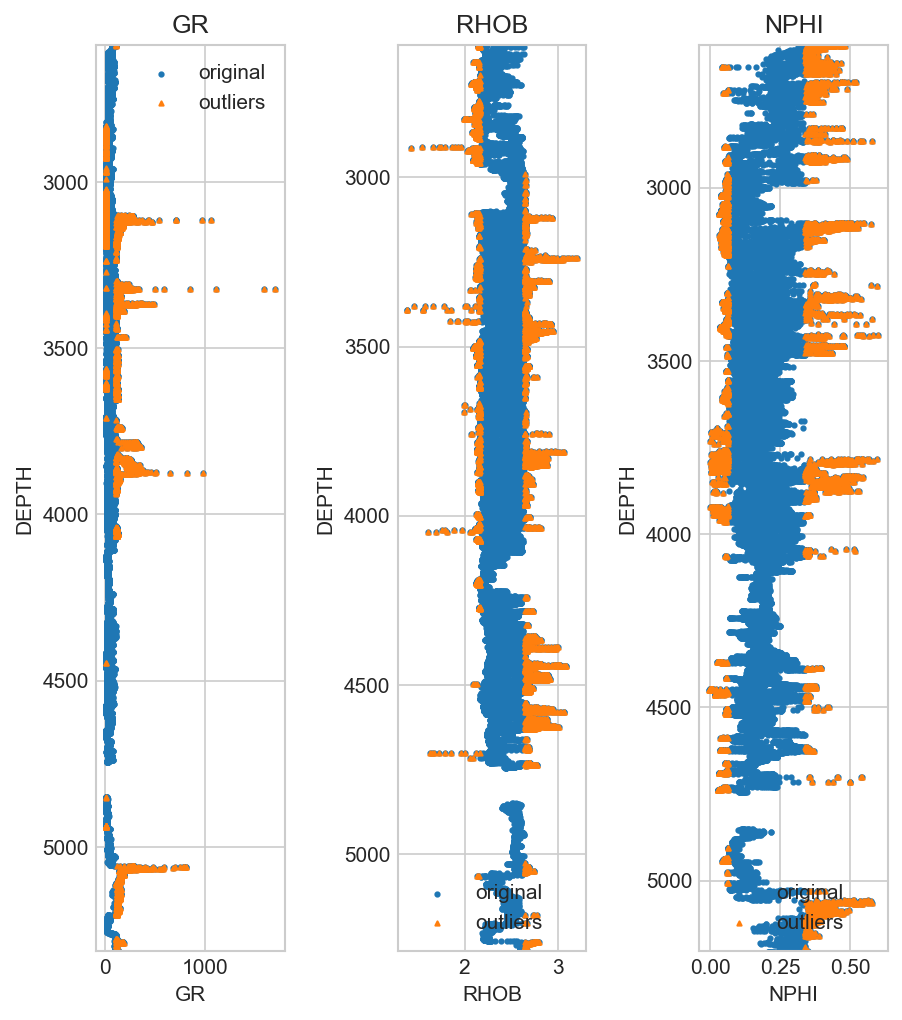

In [278]:
POR = dfm.drop(['BS', 'ROP', 'RM', 'RD', 'PEF', 'DT', 'DTS', 'VCARB', 'VSH', 'SW', 'CALI',
                  'KLOGH', 'SAND_FLAG', 'CARB_FLAG', 'COAL_FLAG'], axis=1) 
print(POR.info())
# drop all nan values from data
POR.dropna(inplace=True)
POR.shape

POR_df=outlier_removal(POR, ind=-1)

Text(0.5, 1, 'DT correlation')

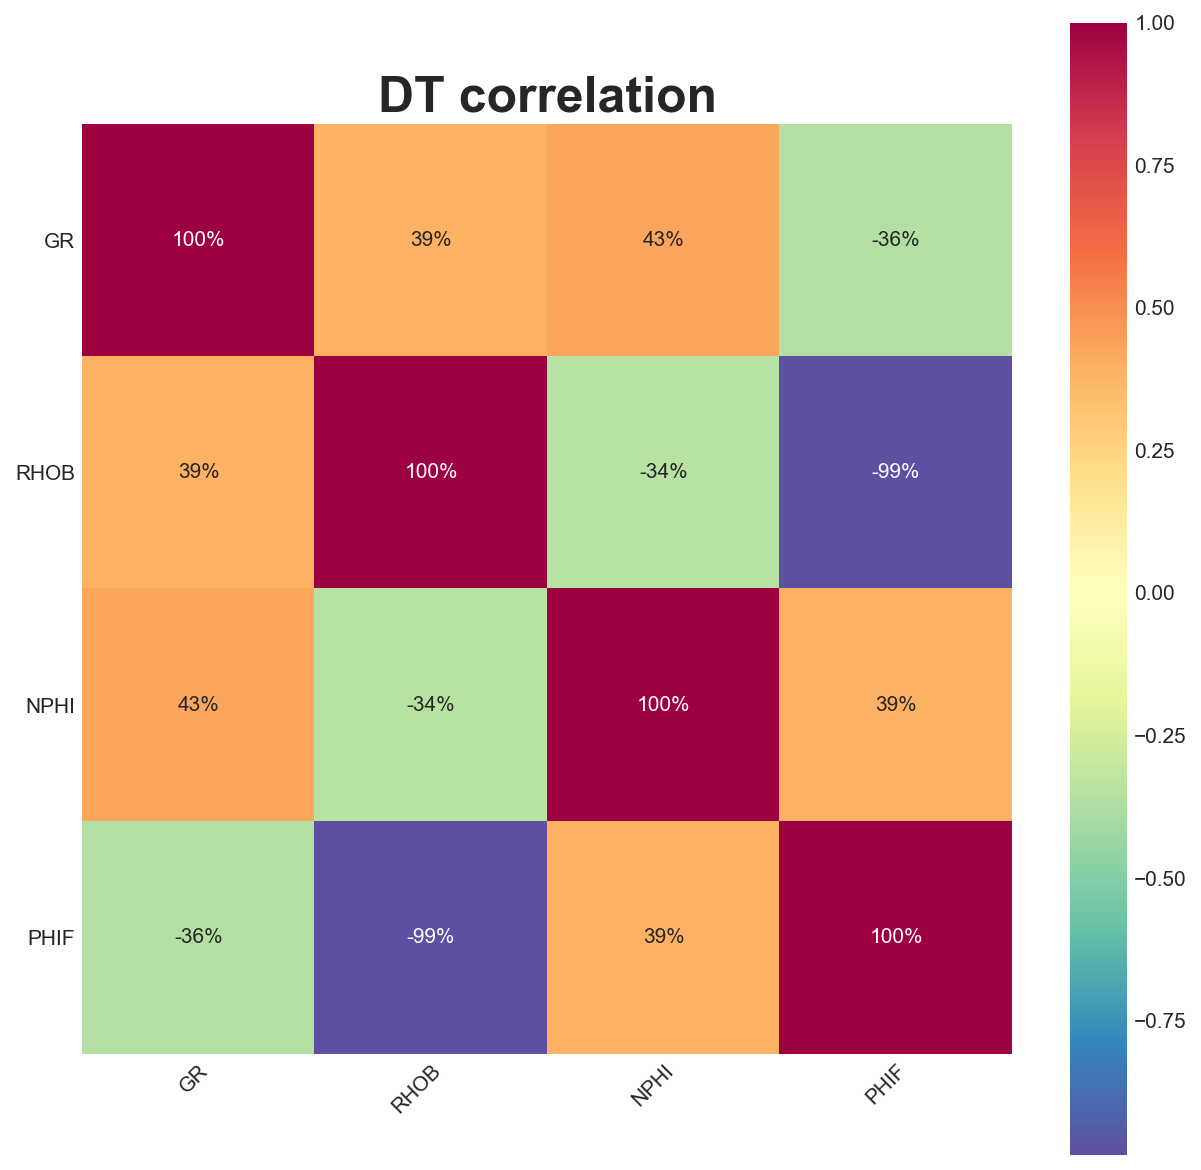

In [279]:
# Visualize correlation
data_scaled = DataFrame(Prescale.fit_transform(POR_df.drop(['WELL_NAME', 'DEPTH'], axis = 1)), 
                        index=POR_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).index,
                        columns=POR_df.drop(['WELL_NAME', 'DEPTH'], axis = 1).columns)
plt.figure(figsize= (10,10))
# Draw a heatmap
ax=sns.heatmap(data_scaled.corr(method='pearson'), annot=True, fmt ='.0%', cmap="Spectral_r", square=True)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
ax.set_title('PHIF correlation',weight='bold', fontsize=24)

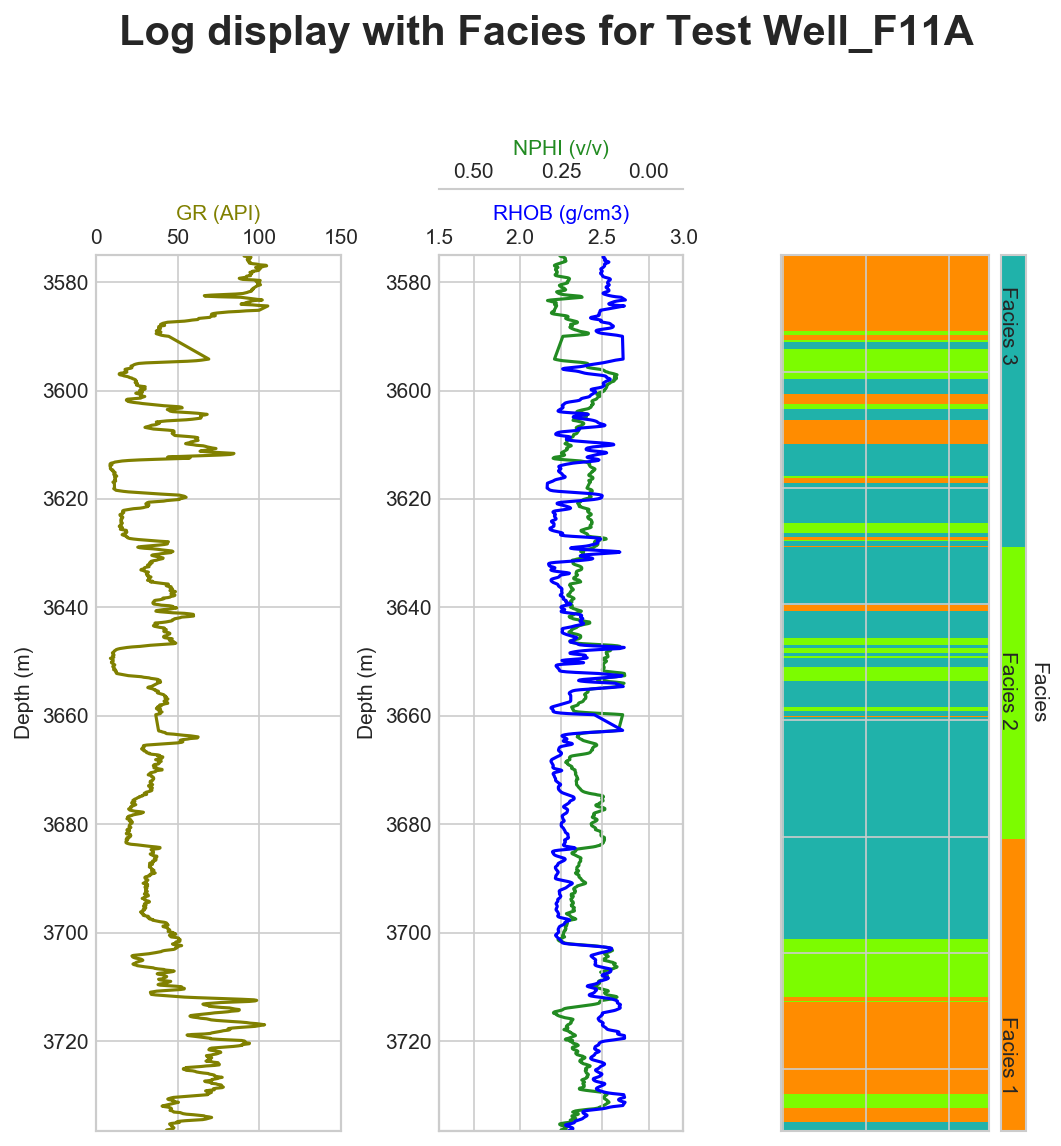

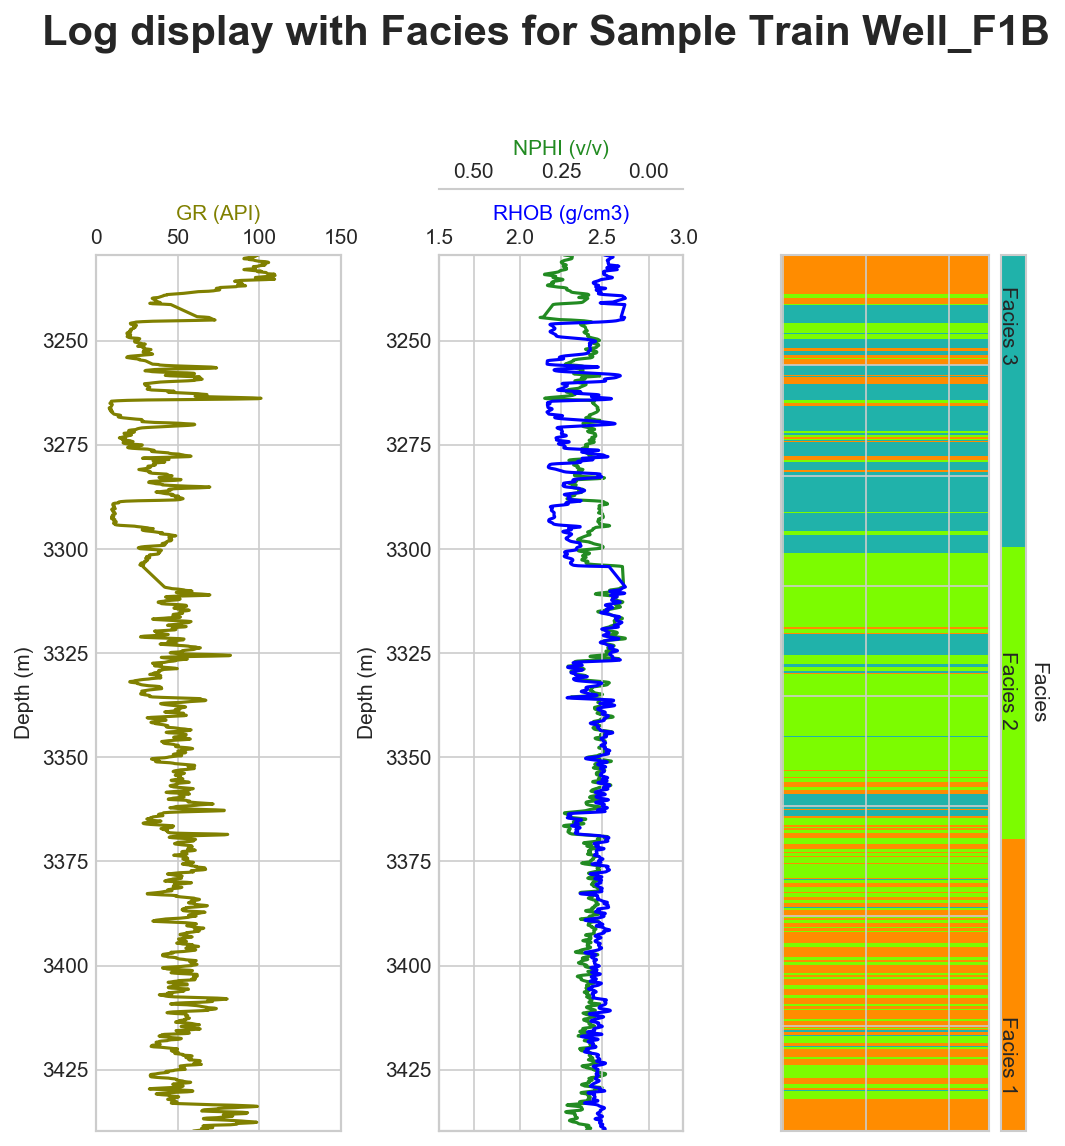

In [281]:
# create blind test data with Well_F11A
POR_blind = POR_df[POR_df['WELL_NAME'] == 'Well_F11A']
POR = POR_df[POR_df['WELL_NAME'] != 'Well_F11A']

# Visualising the zone clusters
log_plot (POR_blind, name='Facies', ycbar=10, title='Log display with Facies for Test')
log_plot (POR[POR['WELL_NAME'] == 'Well_F1B'], name='Facies', ycbar=10,
          title='Log display with Facies for Sample Train')

After applying noise-filter
                  GR          RHOB          NPHI
count  28588.000000  28588.000000  28588.000000
mean      27.127898      2.258622      0.191484
std       10.901414      0.058001      0.030686
min        8.043200      2.166700      0.127900
25%       17.631175      2.210000      0.166000
50%       26.660900      2.250900      0.190800
75%       34.624000      2.298100      0.211000
max       63.265499      2.454000      0.310369


No handles with labels found to put in legend.


GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([  1.,  10., 100.]),
                         'gamma': array([1.00000000e-03, 2.51188643e-02, 6.30957344e-01, 1.58489319e+01])},
             pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
             scoring=['neg_mean_squared_error', 'r2'], verbose=0)
Best: -1.081832 using {'C': 10.0, 'gamma': 0.6309573444801936}
         means     stdev                                       params
rank                                                                 
1    -1.081832  0.096193     {'C': 10.0, 'gamma': 0.6309573444801936}
2    -1.609243  0.250505    {'C': 100.0, 'gamma': 0.6309573444801936}
3    -1.621400  0.1

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Attempting to set identical bottom == top == 0.09389450299739838 results in singular transformations; automatically expanding.
No handles with labels found to put in legend.


GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([  1.,  10., 100.]),
                         'gamma': array([1.00000000e-03, 2.51188643e-02, 6.30957344e-01, 1.58489319e+01])},
             pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
             scoring=['neg_mean_squared_error', 'r2'], verbose=0)
Best: -0.201387 using {'C': 1.0, 'gamma': 0.001}
         means     stdev                                       params
rank                                                                 
1    -0.201387  0.034428                   {'C': 1.0, 'gamma': 0.001}
1    -0.201387  0.034428    {'C': 1.0, 'gamma': 0.025118864315095808}
1    -0.201387  0.034428      {'C

No handles with labels found to put in legend.


GridSearchCV(cv=10, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([  1.,  10., 100.]),
                         'gamma': array([1.00000000e-03, 2.51188643e-02, 6.30957344e-01, 1.58489319e+01])},
             pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
             scoring=['neg_mean_squared_error', 'r2'], verbose=0)
Best: 0.521516 using {'C': 10.0, 'gamma': 0.025118864315095808}
         means     stdev                                       params
rank                                                                 
1     0.521516  0.028193   {'C': 10.0, 'gamma': 0.025118864315095808}
2     0.500880  0.016960                 {'C': 100.0, 'gamma': 0.001}
3     0.475755  0.

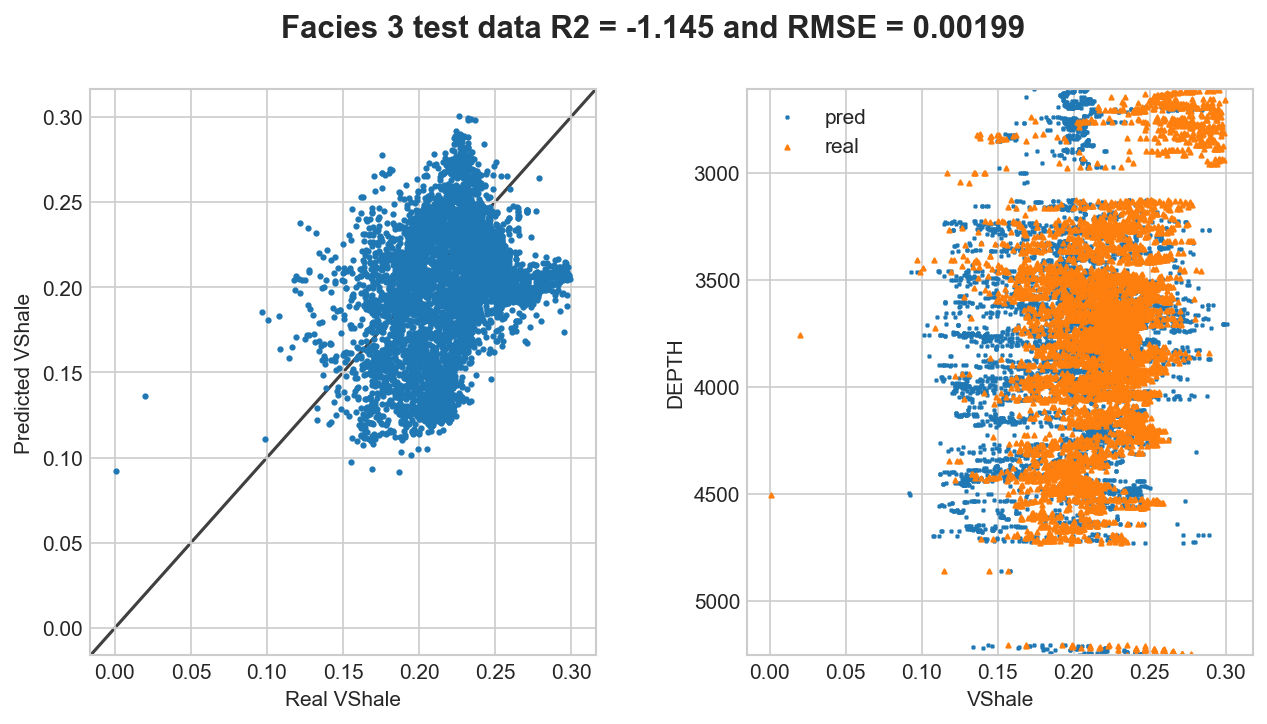

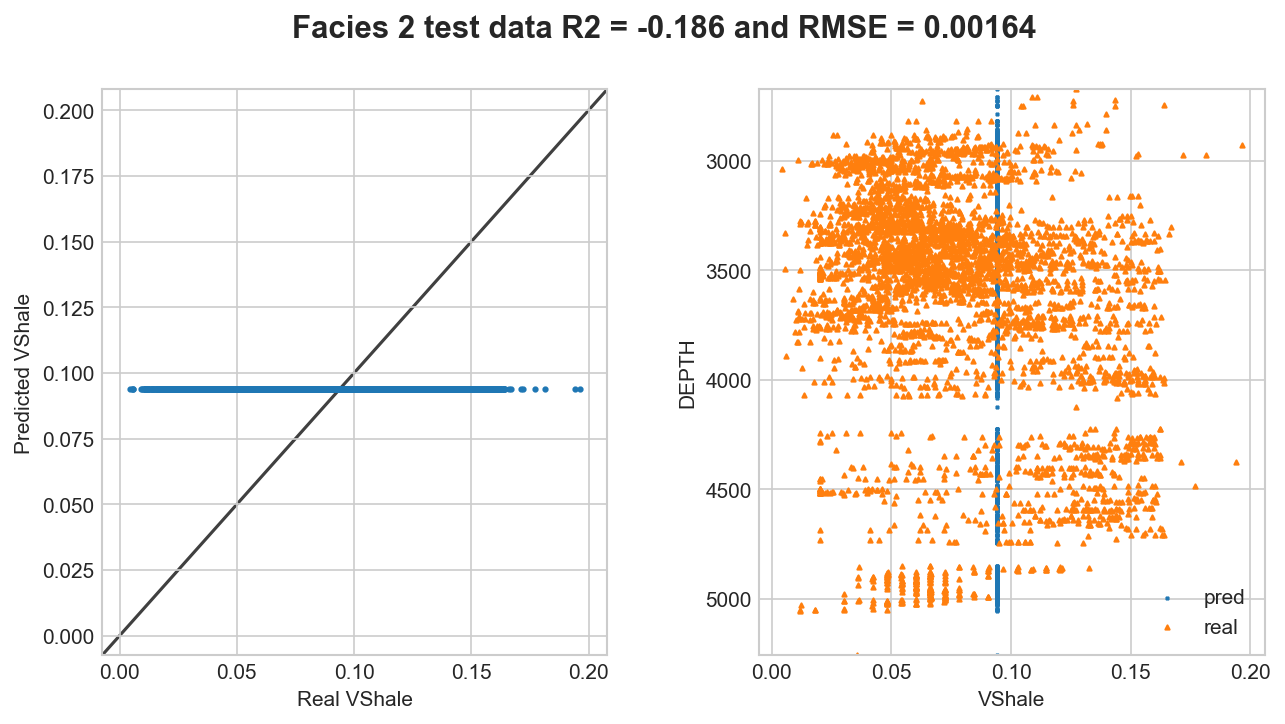

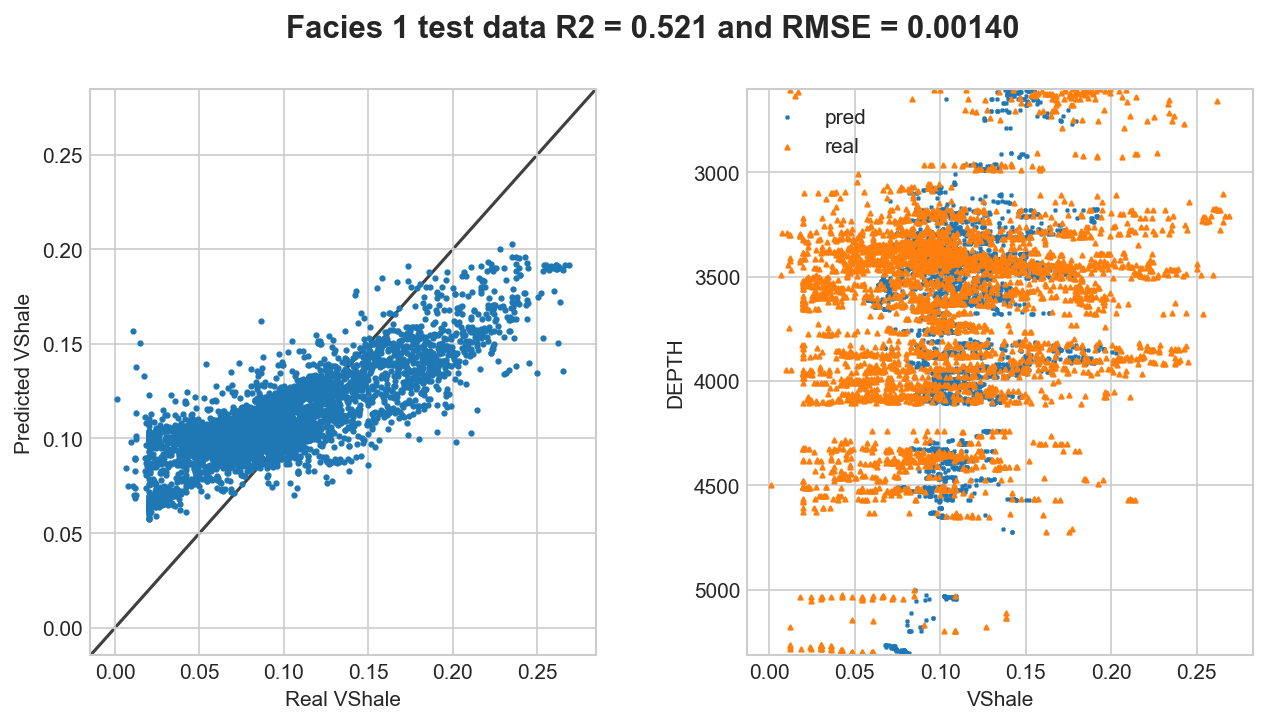

In [282]:
# Split dataset into target and attributes
# arrays for saving predictions
Y_pred_POR=np.zeros(POR_blind.shape[0])
name='PHIF'
for i in POR['Facies'].unique():
    POR_split=POR[POR.Facies.values==i].copy()
    target = POR_split[['DEPTH', 'PHIF']]
    target.set_index('DEPTH', inplace=True)
    attributes = POR_split.drop(['WELL_NAME', 'DEPTH', 'PHIF', 'Facies'], axis = 1)
    attributes = apply_filter(attributes, name=name)
    
    model, Prescale, results = model_predict(attributes,target,'Facies %s' % str(i+1), name=name)
    print(model.best_params_)
    
    #BLIND WELL TEST
    POR_blind_split=POR_blind[POR_blind.Facies.values==i].copy()
    Y_blind = POR_blind_split[['DEPTH', 'PHIF']]
    Y_blind.set_index('DEPTH', inplace=True)
    X_blind = POR_blind_split.drop(['WELL_NAME', 'DEPTH', 'PHIF', 'Facies'], axis = 1)
    X_blind = apply_filter(X_blind, name=name)
    

    # save the prediction
    Y_blind_pred = model.predict(Prescale.transform(X_blind))
    Y_pred_POR[POR_blind.Facies.values==i]=Y_blind_pred
    
Y_test_POR=POR_blind['PHIF'].values

Text(0.5, 1.0, 'R2 = 0.605 and RMSE = 0.00186')

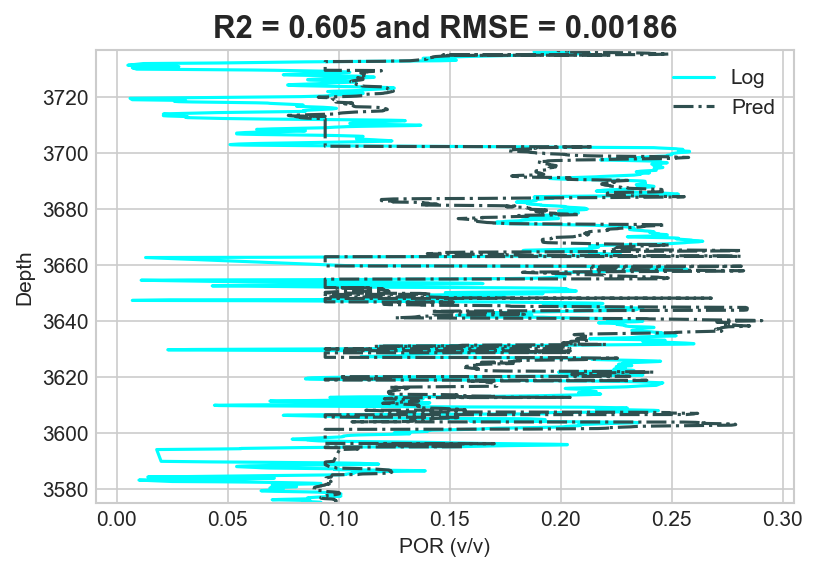

In [283]:
#test the accuracy
mse = mean_squared_error(Y_test_POR, Y_pred_POR)
r2 = r2_score(Y_test_POR, Y_pred_POR)

plt.plot(Y_test_POR, POR_blind.DEPTH, c='cyan')
plt.plot(Y_pred_POR, POR_blind.DEPTH, c='darkslategrey', linestyle='-.')
plt.xlabel('POR (v/v)')
#plt.xlim(0,1) 
plt.ylim(np.min(POR_blind.DEPTH),np.max(POR_blind.DEPTH)) 
plt.ylabel('Depth')
plt.legend(['Log', 'Pred'], loc=0)
plt.title('R2 = {:.3f} and RMSE = {:.5f}'.format(r2, mse), weight='bold', fontsize=15)